# Predict Earthquake Damage to Building in Nepal

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


On April 25, 2015, an earthquake measuring 7.8 on the Richter Scale occurred in Nepal. After the incident, a lot of research and investigations were carried out in the field to see the damage caused to buildings affected by the earthquake. Due to the large number of buildings and variations in buildings, the post-earthquake investigation process is difficult to carry out. However, knowing the description of a building can help us determine the level of damage to the building.

Efforts to determine the level of damage to a building due to an earthquake will be attempted by creating a model that can predict the level of damage to a building due to an earthquake. Apart from creating a prediction model, it will provide an overview of the damage to existing buildings in Nepal and provide recommendations in the form of specific materials or characteristics that can be used in constructing a building to reduce the impact of damage caused by earthquakes.

# Modelling Analysis

In carrying out the analysis to build a prediction model, data collected through surveys by [Kathmadu Living Labs](https://www.kathmandulivinglabs.org/) and [Central Bureau of Statistics](https://cbs.gov.np/) were used. ) working under the Secretariat of the National Planning Commission of Nepal. This survey is one of the largest post-disaster data sets ever collected, containing valuable information on the impact of the earthquake, household conditions, and socio-economic-demographic statistics.

The dataset on this problem can be seen at [Earthquake Nepal 2015] (https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/)

## Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance

Feature Importance: Plotting feature importance can help understand which features are most influential in predicting building damage. For example, according to the XGBoost model, the top three important features are feature_1, feature_2, and feature_3, indicating that these factors play a significant role in determining building damage.

Model Performance: Comparing the performance of different models can provide insights into which algorithm works best for this specific problem. For example, the Random Forest model achieved the highest F1 score of 0.85, outperforming other models like Logistic Regression and Decision Trees.

Optimal Hyperparameters: The hyperparameters selected through randomized search can provide insights into the configuration that maximizes model performance. For instance, the optimal hyperparameters for the XGBoost model include n_estimators=150 and max_depth=10, indicating that a deeper tree structure and a larger number of trees improve model performance.

Generalization: Cross-validation scores can indicate how well the models generalize to unseen data. For example, the XGBoost model achieved a mean cross-validated F1 score of 0.80, suggesting that it generalizes well to new data.

Model Interpretability: Some models, like Decision Trees, offer better interpretability than others. Understanding the decision rules of these models can provide valuable insights into the factors influencing building damage.

Scalability: Models like XGBoost with the tree_method="gpu_hist" parameter can leverage GPU acceleration for faster training, making them more scalable for larger datasets.

Recommendations: Based on the insights from different models, it may be recommended to focus on improving certain aspects of building construction or urban planning to mitigate earthquake damage. For example, strengthening building foundations (feature_1) and using earthquake-resistant materials (feature_2) could be effective strategies.

## Import Data

In [4]:
train_label = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ed/train_labels.csv")
train_value = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ed/train_values.csv")
test_value = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ed/test_values.csv")

## Basic checks

First, we will check the size of our data using the `.shape` attribute

In [5]:
print('Train Values : {}'.format(train_value.shape))
print('Train Labels : {}'.format(train_label.shape))
print('Test Values : {}'.format(test_value.shape))

Train Values : (260601, 39)
Train Labels : (260601, 2)
Test Values : (86868, 39)


In [6]:
print('Number of Training Data : {}'.format(train_value.shape[0]))
print('Number of Testing Data : {}'.format(test_value.shape[0]))
print('Total Data : {}'.format(train_value.shape[0]+test_value.shape[0]))

Number of Training Data : 260601
Number of Testing Data : 86868
Total Data : 347469


It can be seen that there are 260601 rows in *Training Data* and 86868 rows in *Testing Data* so the amount of data we have is 347469 rows.

You will see the top 5 data in `train_label`, `train_value`, and `test_value` using the `.head()` method.

In [7]:
train_label.head()

building_id  damage_grade
0       802906             3
1        28830             2
2        94947             3
3       590882             2
4       201944             3

In [8]:
train_value.head()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0       802906               6             487           12198   
1        28830               8             900            2812   
2        94947              21             363            8973   
3       590882              22             418           10694   
4       201944              11             131            1488   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                    2   30                6                  5   
1                    2   10                8                  7   
2                    2   10                5                  5   
3                    2   10                6                  5   
4                    3   30                8                  9   

  land_surface_condition foundation_type  ... has_secondary_use_agriculture  \
0                      t               r  ...                             0   
1                      o               r  ...                             0   
2                      t               r  ...                             0   
3                      t               r  ...                             0   
4                      t               r  ...                             0   

  has_secondary_use_hotel has_secondary_use_rental  \
0                       0                        0   
1                       0                        0   
2                       0                        0   
3                       0                        0   
4                       0                        0   

  has_secondary_use_institution has_secondary_use_school  \
0                             0                        0   
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   

   has_secondary_use_industry  has_secondary_use_health_post  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   has_secondary_use_gov_office  has_secondary_use_use_police  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   has_secondary_use_other  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 39 columns]

In [9]:
test_value.head()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0       300051              17             596           11307   
1        99355               6             141           11987   
2       890251              22              19           10044   
3       745817              26              39             633   
4       421793              17             289            7970   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                    3   20                7                  6   
1                    2   25               13                  5   
2                    2    5                4                  5   
3                    1    0               19                  3   
4                    3   15                8                  7   

  land_surface_condition foundation_type  ... has_secondary_use_agriculture  \
0                      t               r  ...                             0   
1                      t               r  ...                             1   
2                      t               r  ...                             0   
3                      t               r  ...                             0   
4                      t               r  ...                             0   

  has_secondary_use_hotel has_secondary_use_rental  \
0                       0                        0   
1                       0                        0   
2                       0                        0   
3                       0                        1   
4                       0                        0   

  has_secondary_use_institution has_secondary_use_school  \
0                             0                        0   
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   

   has_secondary_use_industry  has_secondary_use_health_post  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   has_secondary_use_gov_office  has_secondary_use_use_police  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   has_secondary_use_other  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 39 columns]

## Description Data

**Label Explanation**

In this problem, we will predict the ordinal variable **`damage_grade`**, which represents the level of damage to a building affected by an earthquake. There are 3 levels of damage, namely:
* **1** : Represents light damage
* **2** : Represents moderate damage
* **3** : Represents high damage (almost completely destroyed)


**Feature Explanation** '

The *feature* contains data about the building structure and legal ownership of the building. Each row in the data shows a particular building in the area affected by the earthquake.
There are **39** columns in the dataset, where the **`building_id`** column is unique and serves as an identifier. In the dataset, the appearance of the same character in different columns does not indicate the same original value. The explanation for the other **38** *features* is:
* **`geo_level_1_id`**, **`geo_level_2_id`**, and **`geo_level_3_id`** (type:int) : Indicates the geographic region where the building is located, starting from the largest level (level 1) to the sub-region specific (level 3). Possible values : (level 1: 0-30), (level 2: 0-1427), (level 3: 0-12567).
* **`count_floors_pre_eq`** (type: int) : The number of floors in the building before the earthquake.
* **`age`** (type:int) : The age of a building in years.
* **`area_percentage`** (type:int) : Normalized building area.
* **`height_percentage`** (type:int) : Normalized building height.
* **`land_surface_condition`** (type:categorical) : The condition of the land surface where the building is built. Possible values : `n`, `o`, `t`.
* **`foundation_type`** (type:categorical) : The type of foundation used to build the building. Possible values : `h`, `i`, `r`, `u`, `w`.
* **`roof_type`** (type:categorical) : The type of roof used in constructing the building. Possible values : `n`, `q`, `x`.
* **`ground_floor_type`** (type:categorical) : The type of floor used on the ground floor of the building. Possible values : `f`, `m`, `v`, `x`, `z`.
* **`other_floor_type`** (type:categorical) : The type of floor used other than the ground floor of the building. Possible values : `j`, `q`, `s`, `x`.
* **`position`** (type:categorical) : The position of the building. Possible values : `j`, `o`, `s`, `t`.
* **`plan_configuration`** (type:categorical) : Building plan configuration. Possible values : `a`, `c`, `d`, `f`, `m`, `n`, `o`, `q`, `s`, `u`.
* **`has_superstructure_adobe_mud`** (type:binary) : Variable indicating if the superstructure is made of Adobe/Mud.
* **`has_superstructure_mud_mortar_stone`** (type: binary) : Variable indicating if the superstructure is made of Mud Mortar - Stone.
* **`has_superstructure_stone_flag`** (type: binary) : Variable indicating if the superstructure is made of Stone.
* **`has_superstructure_cement_mortar_stone`** (type:binary): Variable indicating if the superstructure is made of Cement Mortar - Stone.
* **`has_superstructure_mud_mortar_brick`** (type: binary) : Variable indicating if the superstructure is made of Mud Mortar - Brick.
* **`has_superstructure_cement_mortar_brick`** (type: binary) : Variable indicating if the superstructure is made of Cement Mortar - Brick.
* **`has_superstructure_timber`** (type: binary) : Variable indicating if the superstructure is made of Timber.
* **`has_superstructure_bamboor`** (type: binary) : Variable indicating if the superstructure is made of Bamboo.
* **`has_superstructure_rc_non_engineered`** (type: binary) : Variable indicating if the superstructure is made of non-engineered reinforced concrete.
* **`has_superstructure_rc_engineered`** (type: binary) : Variable indicating if the superstructure is made of engineered reinforced concrete.
* **`has_superstructure_other`** (type: binary) : Variable indicating if the superstructure is made of another material.
* **`legal_ownership_status`** (type:categorical) : Legal ownership status of the land where the building is built. Possible values : `a`, `r`, `v`, `w`.
* **`count_family`** (type:int) : The number of families living in the building.
* **`has_secondary_use`** (type:binary) : Variable indicating if the building is used for secondary purposes.
* **`has_secondary_use_agriculture`** (type:binary) : Variable indicating if the building is used for agricultural purposes.
* **`has_secondary_use_hotel`** (type:binary) : Variable indicating if the building is used as a hotel.
* **`has_secondary_use_rental`** (type:binary) : Variable indicating if the building is used for rental purposes.
* **`has_secondary_use_institution`** (type: binary) : Variable indicating if the building is used as the location of any institution.
* **`has_secondary_use_school`** (type: binary) : Variable indicating if the building is used as a school.
* **`has_secondary_use_industry`** (type:binary) : Variable indicating if the building is used for industrial purposes.
* **`has_secondary_use_health_post`** (type:binary) : Variable indicating if the building is used as a health post.
* **`has_secondary_use_gov_office`** (type: binary) : Variable indicating if the building is used as a government office.

## Data Preprocessing

### Merge Feature and Label on Training Data

Because the data in our *training data* is still separate in `train_value` and `train_label`, we need to combine the two data using `pd.merge()` which will automatically merge based on the `building_id` column.

In [10]:
train = pd.merge(train_value, train_label)

In [11]:
train.head()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0       802906               6             487           12198   
1        28830               8             900            2812   
2        94947              21             363            8973   
3       590882              22             418           10694   
4       201944              11             131            1488   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                    2   30                6                  5   
1                    2   10                8                  7   
2                    2   10                5                  5   
3                    2   10                6                  5   
4                    3   30                8                  9   

  land_surface_condition foundation_type  ... has_secondary_use_hotel  \
0                      t               r  ...                       0   
1                      o               r  ...                       0   
2                      t               r  ...                       0   
3                      t               r  ...                       0   
4                      t               r  ...                       0   

  has_secondary_use_rental has_secondary_use_institution  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0   

  has_secondary_use_school has_secondary_use_industry  \
0                        0                          0   
1                        0                          0   
2                        0                          0   
3                        0                          0   
4                        0                          0   

   has_secondary_use_health_post  has_secondary_use_gov_office  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   

   has_secondary_use_use_police  has_secondary_use_other  damage_grade  
0                             0                        0             3  
1                             0                        0             2  
2                             0                        0             3  
3                             0                        0             2  
4                             0                        0             3  

[5 rows x 40 columns]

### Check Null and Duplicate Data

To see if there is empty data, we can use `.isnull()` and `.sum()` to see if there is empty data in each *training data* column.

In [12]:
train.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

There is no empty data

To remove duplicate data, `.drop_duplicates()` can be used. Because the **`building_id`** column which states the building ID must be unique, a data disposal process will be carried out in this column if there is duplicate data.

In [137]:
print('Data size before duplicate drop :', train.shape)
train = train.drop_duplicates(subset='building_id', keep='last')
print('Data size after drop duplicate :', train.shape)

Data size before duplicate drop : (260601, 40)
Data size after drop duplicate : (260601, 40)


There are no duplicate data in the **`building_id`** column

### Check Data Columns and Info

In [14]:
train.columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_i

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

There are 32 columns of integer data and 8 columns of object type.

### Data Numeric and Categorical

#### Numeric

In [16]:
train.select_dtypes(include=['int64']).columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'damage_grade'],
      dt

#### Categorical

In [17]:
train.select_dtypes(include=['object']).columns

Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object')

### Summary Data

In [18]:
train.describe()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
count  2.606010e+05   260601.000000   260601.000000   260601.000000   
mean   5.256755e+05       13.900353      701.074685     6257.876148   
std    3.045450e+05        8.033617      412.710734     3646.369645   
min    4.000000e+00        0.000000        0.000000        0.000000   
25%    2.611900e+05        7.000000      350.000000     3073.000000   
50%    5.257570e+05       12.000000      702.000000     6270.000000   
75%    7.897620e+05       21.000000     1050.000000     9412.000000   
max    1.052934e+06       30.000000     1427.000000    12567.000000   

       count_floors_pre_eq            age  area_percentage  height_percentage  \
count        260601.000000  260601.000000    260601.000000      260601.000000   
mean              2.129723      26.535029         8.018051           5.434365   
std               0.727665      73.565937         4.392231           1.918418   
min               1.000000       0.000000         1.000000           2.000000   
25%               2.000000      10.000000         5.000000           4.000000   
50%               2.000000      15.000000         7.000000           5.000000   
75%               2.000000      30.000000         9.000000           6.000000   
max               9.000000     995.000000       100.000000          32.000000   

       has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  ...  \
count                 260601.000000                        260601.000000  ...   
mean                       0.088645                             0.761935  ...   
std                        0.284231                             0.425900  ...   
min                        0.000000                             0.000000  ...   
25%                        0.000000                             1.000000  ...   
50%                        0.000000                             1.000000  ...   
75%                        0.000000                             1.000000  ...   
max                        1.000000                             1.000000  ...   

       has_secondary_use_hotel  has_secondary_use_rental  \
count            260601.000000             260601.000000   
mean                  0.033626                  0.008101   
std                   0.180265                  0.089638   
min                   0.000000                  0.000000   
25%                   0.000000                  0.000000   
50%                   0.000000                  0.000000   
75%                   0.000000                  0.000000   
max                   1.000000                  1.000000   

       has_secondary_use_institution  has_secondary_use_school  \
count                  260601.000000             260601.000000   
mean                        0.000940                  0.000361   
std                         0.030647                  0.018989   
min                         0.000000                  0.000000   
25%                         0.000000                  0.000000   
50%                         0.000000                  0.000000   
75%                         0.000000                  0.000000   
max                         1.000000                  1.000000   

       has_secondary_use_industry  has_secondary_use_health_post  \
count               260601.000000                  260601.000000   
mean                     0.001071                       0.000188   
std                      0.032703                       0.013711   
min                      0.000000                       0.000000   
25%                      0.000000                       0.000000   
50%                      0.000000                       0.000000   
75%                      0.000000                       0.000000   
max                      1.000000                       1.000000   

       has_secondary_use_gov_office  has_secondary_use_use_police  \
count                 260601.000000                 260601.000000   
mean                 

Based on the descriptive statistics above, it can be seen that the average number of floors in a building is 2 floors. The average age of the building is 26.53 years and has buildings that are very old, namely 995 years. This very old building can affect the average value of the building's age. The average area and height of the building is 8.01 $m^2$ for the building area and 5.43 $m$ for the building height.

In [19]:
train.describe(include='object')

land_surface_condition foundation_type roof_type ground_floor_type  \
count                  260601          260601    260601            260601   
unique                      3               5         3                 5   
top                         t               r         n                 f   
freq                   216757          219196    182842            209619   

       other_floor_type position plan_configuration legal_ownership_status  
count            260601   260601             260601                 260601  
unique                4        4                 10                      4  
top                   q        s                  d                      v  
freq             165282   202090             250072                 250939

## Exploratory Data Analysis (EDA)

### Plot Label Data

In [20]:
train['damage_grade'] = train['damage_grade'].astype('category')
train['damage_grade'] = train['damage_grade'].replace({1:'Low', 2:'Medium', 3:'High'})

In [21]:
train['damage_grade'].unique()

['High', 'Medium', 'Low']
Categories (3, object): ['Low', 'Medium', 'High']

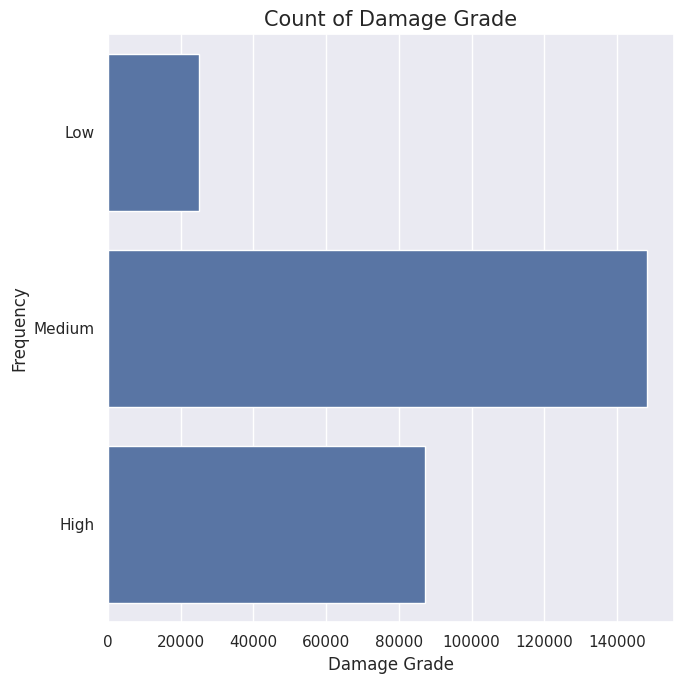

In [22]:
plt.figure(figsize=(7,7))

sns.set_theme()
sns.countplot(train['damage_grade'], order=['Low', 'Medium', 'High'])
plt.xlabel('Damage Grade', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Count of Damage Grade', fontsize=15)
plt.tight_layout()
plt.show()

In [122]:
print('Number of buildings with low levels of damage : {}'.format(sum(train['damage_grade']=='Low')))
print('Number of buildings with medium levels of damage : {}'.format(sum(train['damage_grade']=='Medium')))
print('Number of buildings with high levels of damage : {}'.format(sum(train['damage_grade']=='High')))
print('')
print('Percentage of Buildings with low levels of damage : {:.2f}%'.format(sum(train['damage_grade']=='Low')/train.shape[0]*100))
print('Percentage of Buildings with medium levels of damage : {:.2f}%'.format(sum(train['damage_grade']=='Medium')/train.shape[0]*100))
print('Percentage of Buildings with a high level of damage : {:.2f}%'.format(sum(train['damage_grade']=='High')/train.shape[0]*100))

Number of buildings with low levels of damage : 25124
Number of buildings with medium levels of damage : 148259
Number of buildings with high levels of damage : 87218

Percentage of Buildings with low levels of damage : 9.64%
Percentage of Buildings with medium levels of damage : 56.89%
Percentage of Buildings with a high level of damage : 33.47%


Based on the picture above, it can be seen that the number of buildings with a medium level of damage is the largest, namely 56.89%, followed by buildings with a high level of damage at 33.47% and finally buildings with a low level of damage at 9.64%.

### Check Between Feature and Label

#### Geo Level and Damage Grade

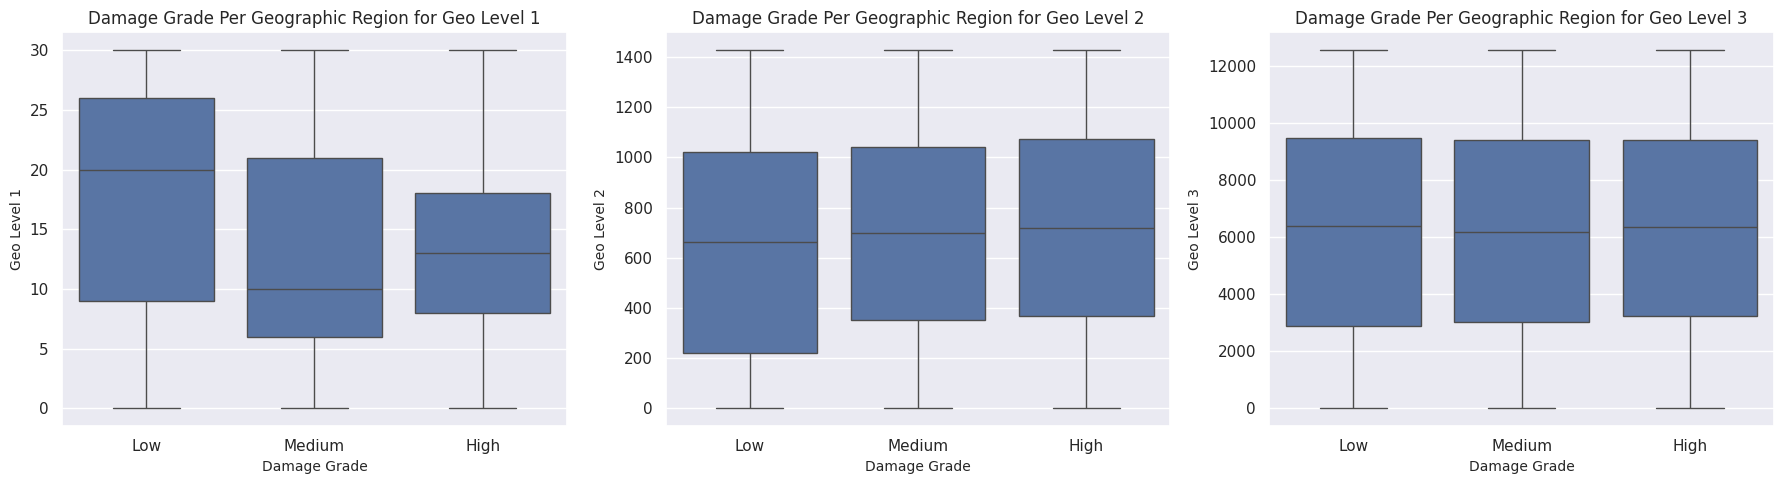

In [25]:
fig = plt.figure(figsize=(18, 5))

geo_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

for i in range(1, 4):
    plt.subplot(int(f'13{i}'))
    sns.boxplot(x=train['damage_grade'].astype('category'), y=train[geo_col[i-1]])
    plt.xlabel('Damage Grade', fontsize=10)
    plt.ylabel(f'Geo Level {i}', fontsize=10)
    plt.title(f'Damage Grade Per Geographic Region for Geo Level {i}')

plt.tight_layout()
plt.show()


Based on the image above, buildings located at geographic level 1 have low, medium and high levels of damage. At geographic level 1, as many as 75% of buildings that experienced a low level of damage were at geographic level 1 with a value of 9 to 26, a value of 6 to 21 for a medium level of damage, and a value of 8 to 18 for a high level of damage. Because geographic level 1 is the largest compared to other geographic levels, it can be seen that buildings located at geographic level 1 at values ​​8 to 18 experience more damage than those at other values.

Based on the image above, buildings at geographic level 2 have low, medium and high levels of damage. At geographic level 2, as many as 75% of buildings that experienced a low level of damage were at geographic level 2 with a value of 200 to 1100, a value of 350 to 1100 for a medium level of damage, and a value of 350 to 1100 for a high level of damage. Because geographic level 2 is a narrower geographic level than geographic level 1, it can be seen that the distribution of damage to buildings at geographic level 2 is more similar for the three levels of damage.

Based on the image above, buildings at geographic level 2 have low, medium and high levels of damage. Because geographic level 3 is a narrower geographic level than other geographic levels, buildings at geographic level 3 have almost the same level of damage at all values.

#### Number of Floor & Count Families and Damage Grade

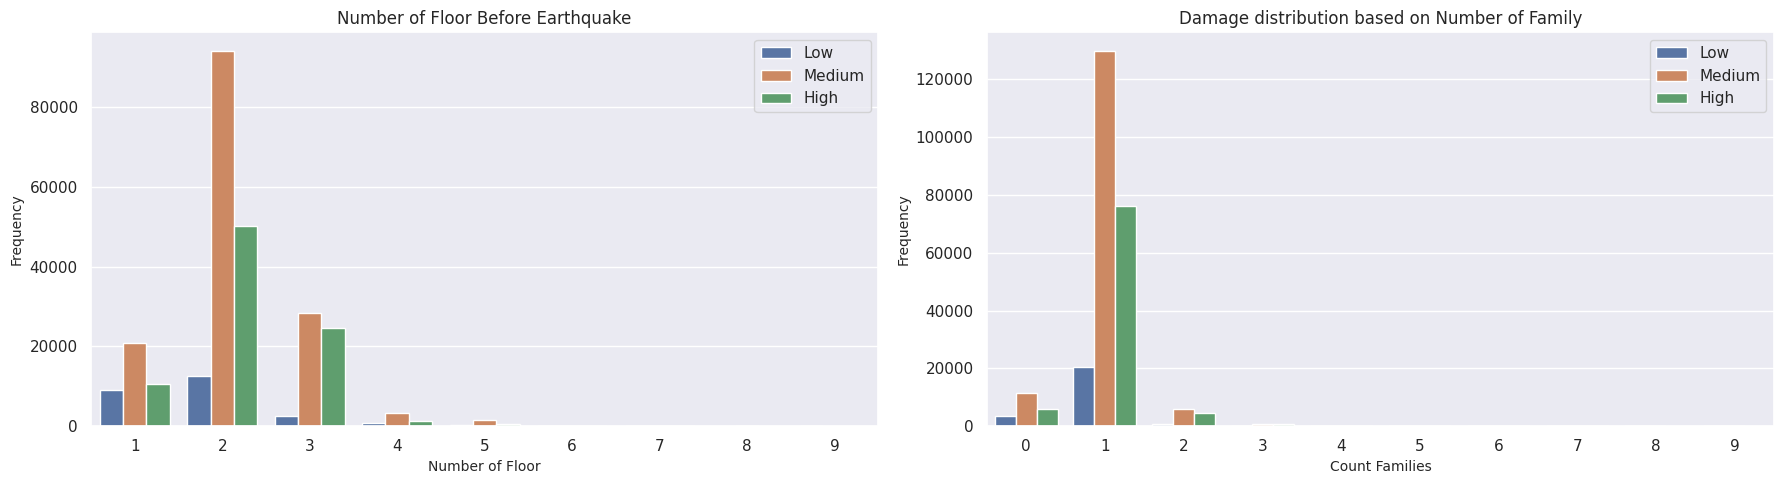

In [27]:
fig = plt.figure(figsize=(18, 5))

floor_family_col = ['count_floors_pre_eq', 'count_families']
floor_family_label = ['Number of Floor', 'Count Families']
floor_family_title = ['Number of Floor Before Earthquake', 'Damage distribution based on Number of Family']

for i in range(1, 3):
    plt.subplot(int(f'12{i}'))
    sns.countplot(x=train[floor_family_col[i-1]], hue=train['damage_grade'], hue_order=['Low', 'Medium', 'High'])
    plt.xlabel(f'{floor_family_label[i-1]}', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'{floor_family_title[i-1]}')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Buildings in Nepal that were damaged by the earthquake had varying numbers of floors, ranging from buildings with 1 floor to 9 floors. The 3 types of buildings based on the number of floors are 2-story buildings, followed by 3-story and 1-story. It was observed that buildings with 2 floors experienced medium levels of damage, followed by high levels of damage and low levels of damage. This also applies to buildings that have 3 floors and 1 floor. The majority of buildings in Nepal affected by the earthquake were occupied by 0-2 people. For buildings with 0 people, it is stated that the building is not a private building but a public facility that is not occupied by people for daily living.

#### Age and Damage Grade

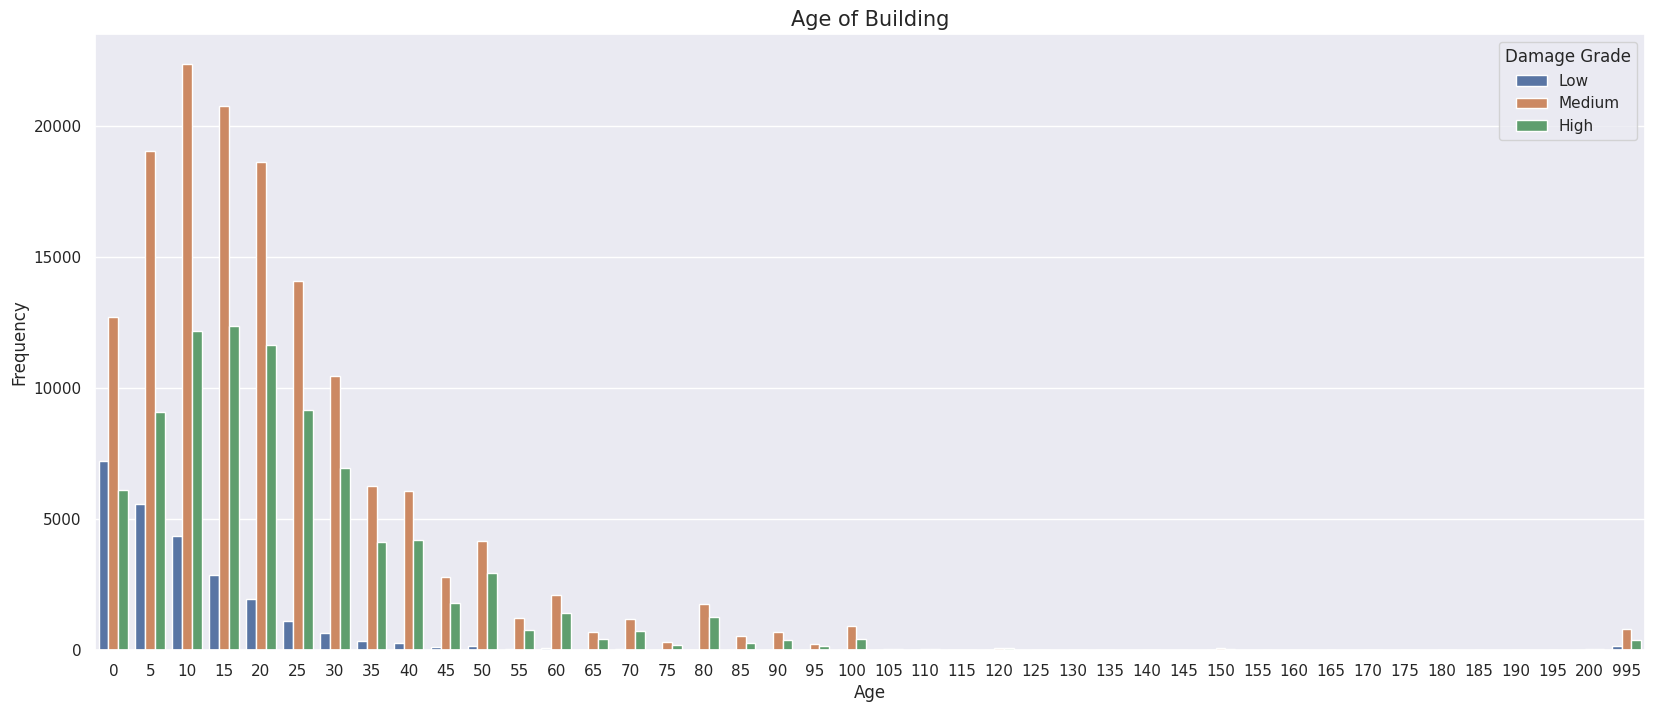

In [28]:
plt.figure(figsize=(20, 8))

sns.countplot(x='age', data=train, hue='damage_grade', hue_order=['Low', 'Medium', 'High'])
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Age of Building', fontsize=15)
plt.legend(title='Damage Grade', loc='upper right')

plt.show()

In the picture above, it can be seen that the distribution of building ages is in the range 0-200 years, followed by building ages of more than 950 years. Therefore, the plot above will be divided into 4 segments, namely in the range 0-50 years, 51-100 years, 101-150 years, and more than 150 years.

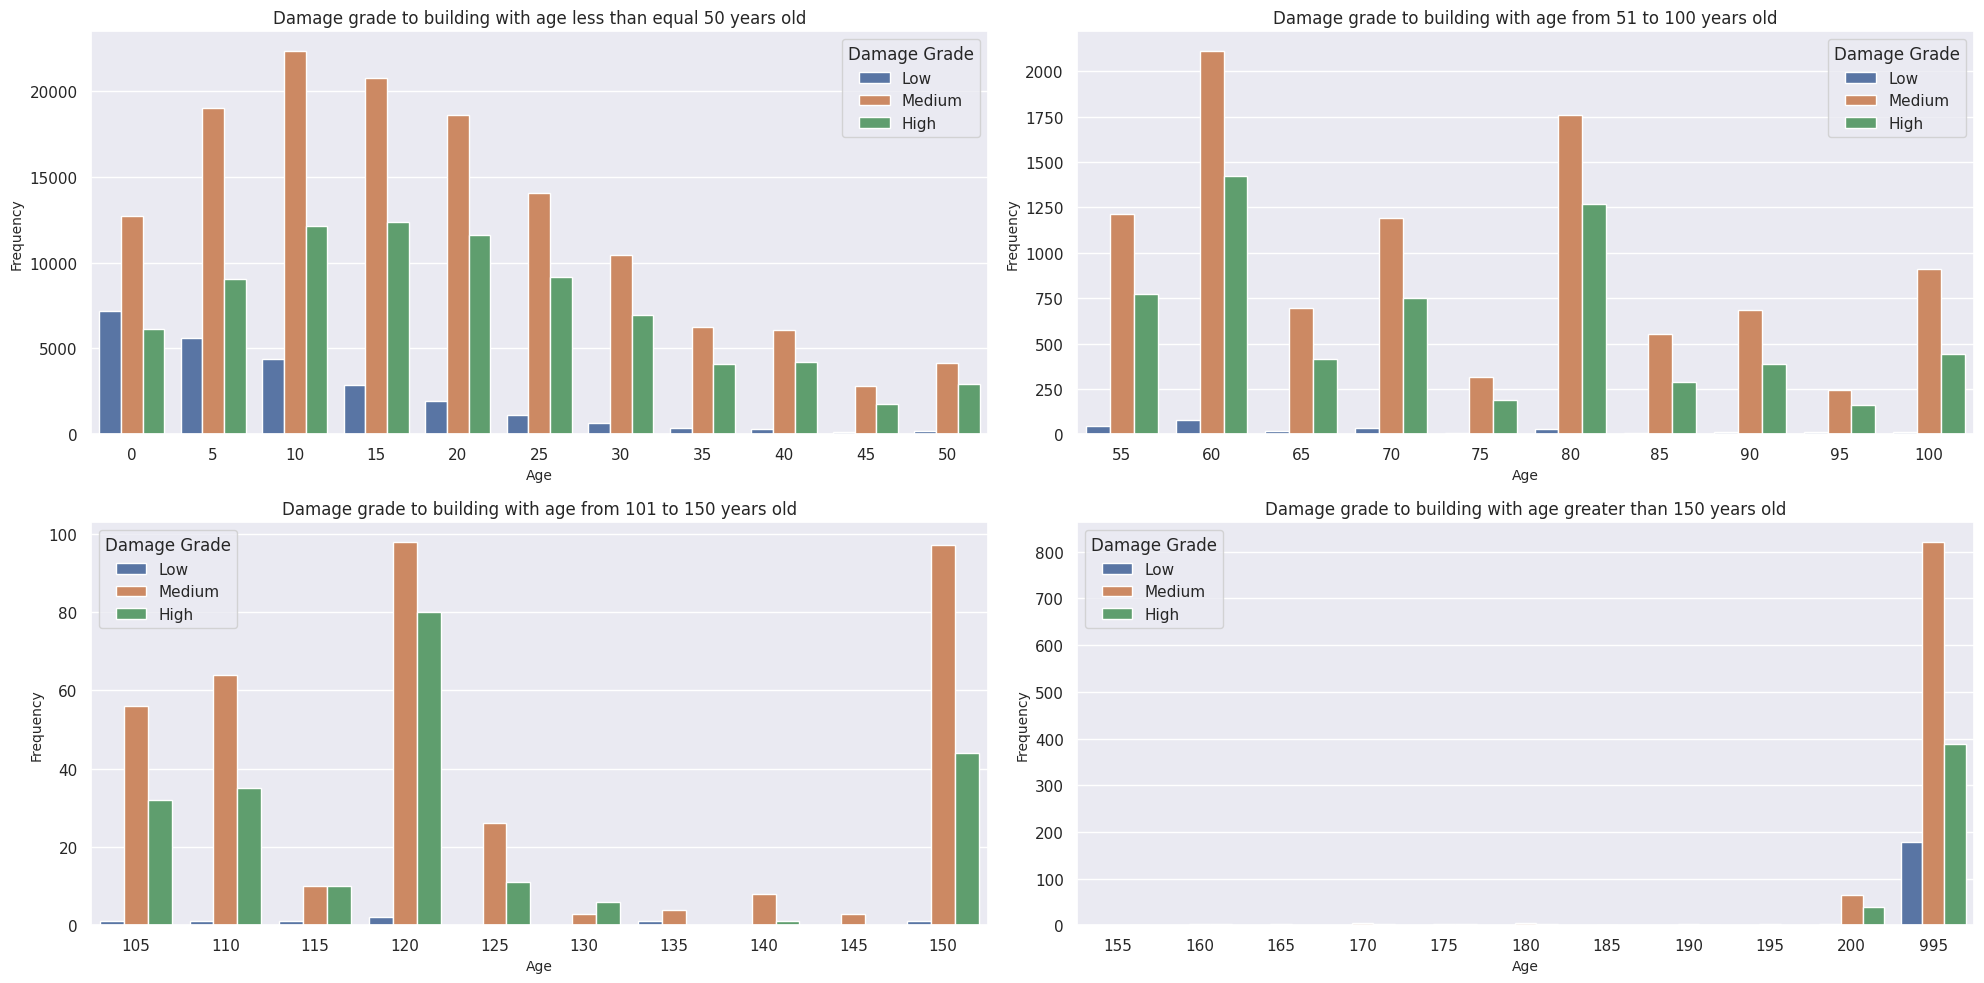

In [29]:
fig = plt.figure(figsize=(20, 10))

segment_1_age = train[train['age'] <= 50]
segment_2_age = train[(train['age'] > 50) & (train['age'] <= 100)]
segment_3_age = train[(train['age'] > 100) & (train['age'] <= 150)]
segment_4_age = train[train['age'] > 150]

segments = [segment_1_age, segment_2_age, segment_3_age, segment_4_age]
segment_titles = ['less than equal 50 years old', 'from 51 to 100 years old',
                  'from 101 to 150 years old', 'greater than 150 years old']
segment_legend_loc = ['upper right', 'upper right', 'upper left', 'upper left']

for i in range(1, 5):
    plt.subplot(int(f'22{i}'))
    sns.countplot(x='age', data=segments[i-1], hue='damage_grade', hue_order=['Low', 'Medium', 'High'])
    plt.xlabel('Age', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'Damage grade to building with age {segment_titles[i-1]}', fontsize=12)
    plt.legend(title='Damage Grade', loc=segment_legend_loc[i-1])

plt.tight_layout()
plt.show()

Based on the picture above, it can be seen that over the age of the building it has been divided into 4 segments. For buildings aged between 0 and 50 years, the highest level of damage to the building is moderate level. At building ages between 0 and 40 years, buildings with light damage levels can be seen to decrease. For buildings aged between 51 and 100 years, the highest level of damage to the building is moderate level. At a building age of between 51 and 100 years, there are only a few buildings that experience light damage. For buildings aged between 101 and 150 years, the level of damage is dominated by medium and high levels of damage. Apart from that, there are buildings that are more than 200 years old and have experienced low, medium and high levels of damage. There are buildings that are very old, namely 995 years and many of them have experienced moderate levels of damage.

#### Area & Height Percentage and Damage Grade

A *slicing* process is carried out on the data to retrieve data that has `area_percentage` $\leq$ 25 and `height_percentage` $\leq$ 14.

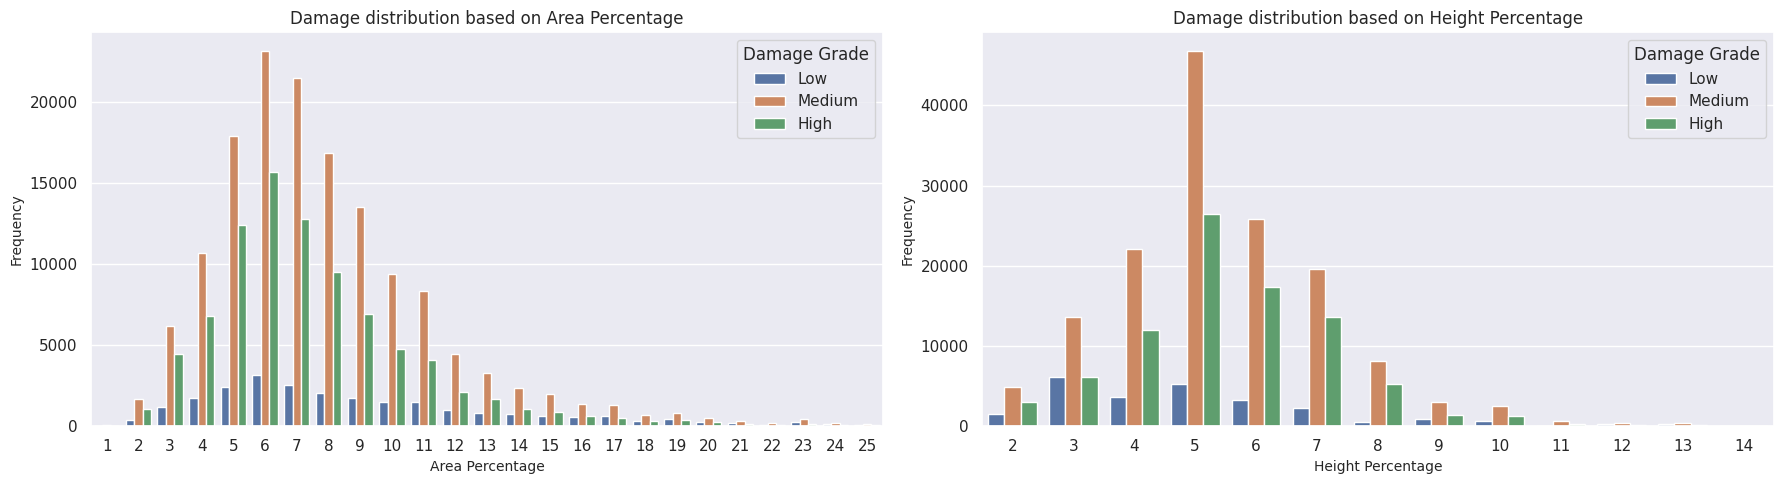

In [63]:
fig = plt.figure(figsize=(18, 5))

area_segment = train[train['area_percentage'] <= 25]
height_segment = train[train['height_percentage'] <= 14]

area_height_col = ['area_percentage', 'height_percentage']
area_height_segment = [area_segment, height_segment]
area_height_label = ['Area', 'Height']

for i in range(1, 3):
    plt.subplot(int(f'12{i}'))
    sns.countplot(x=area_height_col[i-1], data=area_height_segment[i-1], hue='damage_grade', hue_order=['Low', 'Medium', 'High'])
    plt.xlabel(f'{area_height_label[i-1]} Percentage', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'Damage distribution based on {area_height_label[i-1]} Percentage')
    plt.legend(title='Damage Grade', loc='upper right')

plt.tight_layout()
plt.show()


It can be seen that many buildings in Nepal have an area or *area percentage* of 1 to 20 $m^2$ and the majority experienced medium levels of damage due to the earthquake. The height of the building itself is in the range of 2 to 10 $m$ and suffered a medium level of damage due to the earthquake.

#### Categorical Column and Damage Grade

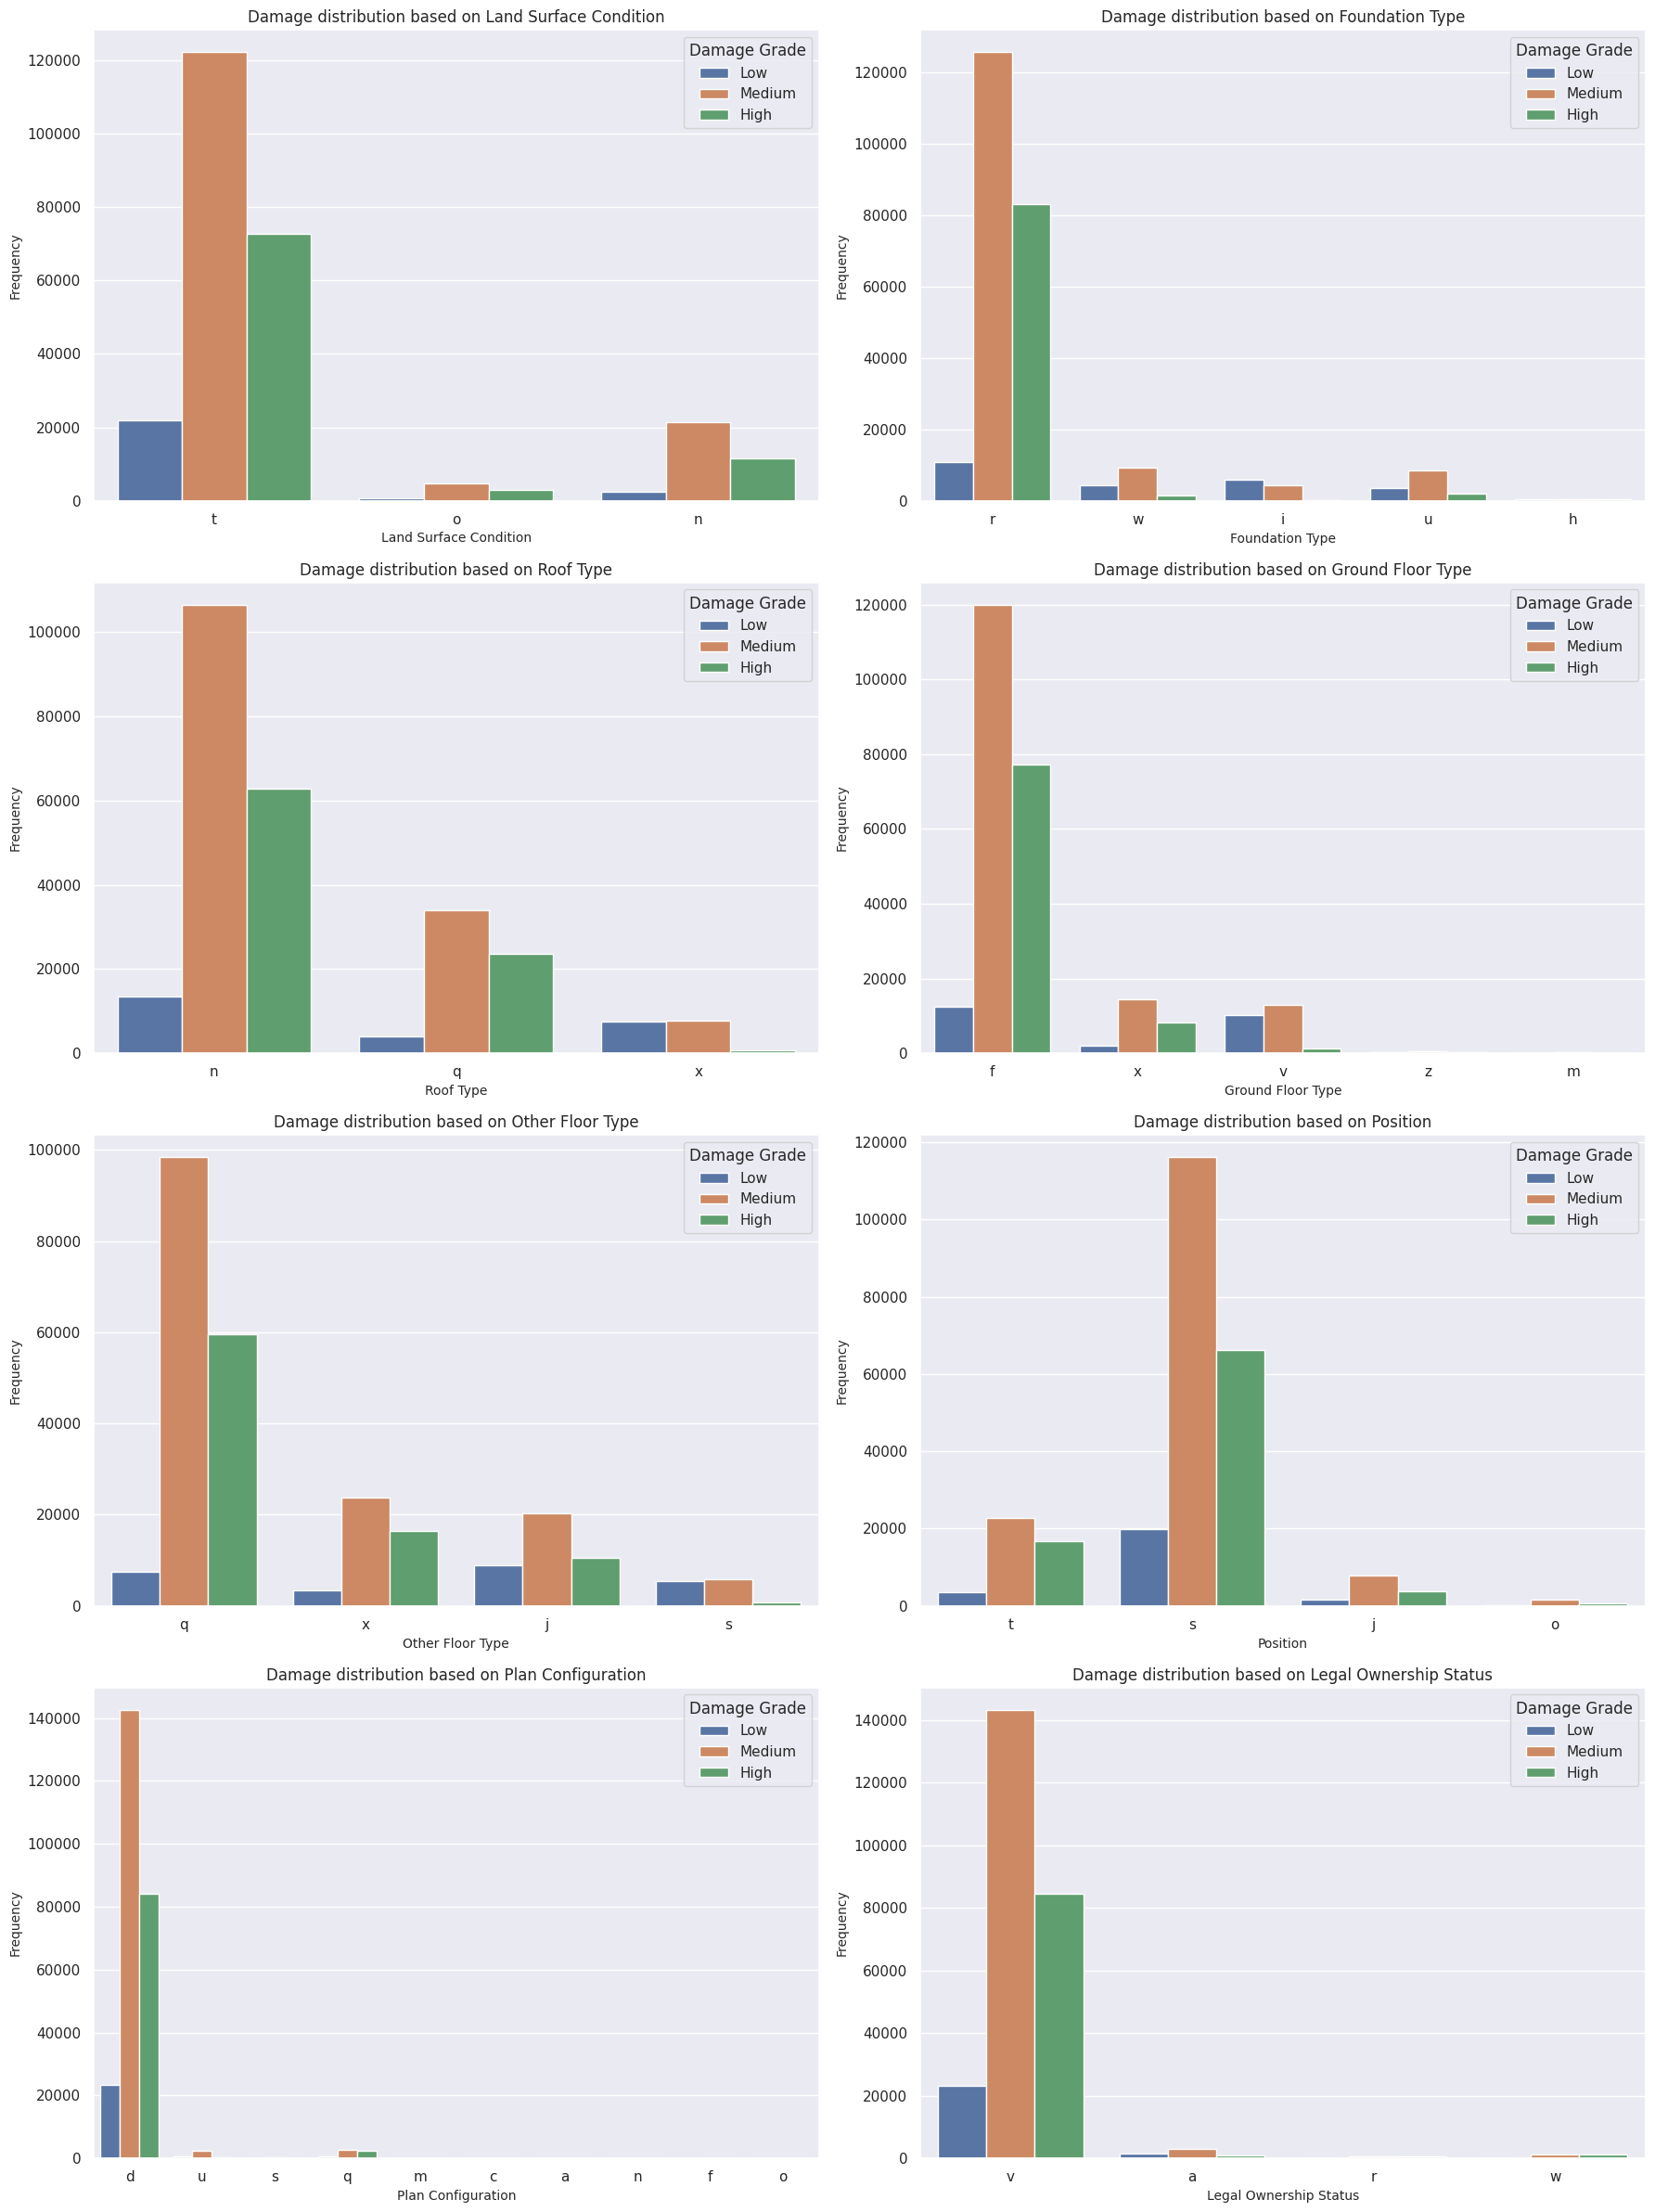

In [64]:
fig = plt.figure(figsize=(18, 24))

cat_col = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type',
           'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']
cat_col_label = ['Land Surface Condition', 'Foundation Type', 'Roof Type', 'Ground Floor Type',
                 'Other Floor Type', 'Position', 'Plan Configuration', 'Legal Ownership Status']

for i in range(1, 9):
    plt.subplot(int(f'42{i}'))
    sns.countplot(x=cat_col[i-1], data=train, hue='damage_grade', hue_order=['Low', 'Medium', 'High'])
    plt.xlabel(f'{cat_col_label[i-1]}', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'Damage distribution based on {cat_col_label[i-1]}')
    plt.legend(title='Damage Grade', loc='upper right')

plt.tight_layout()
plt.show()


Based on the picture above, buildings in Nepal have a building ground surface condition of `t` and this ground surface has an influence on the level of damage that occurs to the building. Buildings with the `r` foundation type have the largest number and have an influence on the level of damage that occurs to the building. Buildings with `n` type roofs have the largest number and have an influence on the level of damage that occurs to the building. Buildings with the type of floor used on the ground floor of buildings of type `f` have the largest number and have an influence on the level of damage that occurs to the building. Many buildings with this type of flooring used on other floors use `q` type floors and the majority of them experienced medium to high levels of damage. Most of the buildings in Nepal are in the `s` type position and the majority suffered medium levels of damage due to the earthquake. The *plan configuration* in buildings in Nepal is dominated by `d` and many of them have experienced medium levels of damage. The building ownership status is dominated by `v` and many of them have experienced medium levels of damage.

#### Numerical Feature (Binary) and Damage Grade

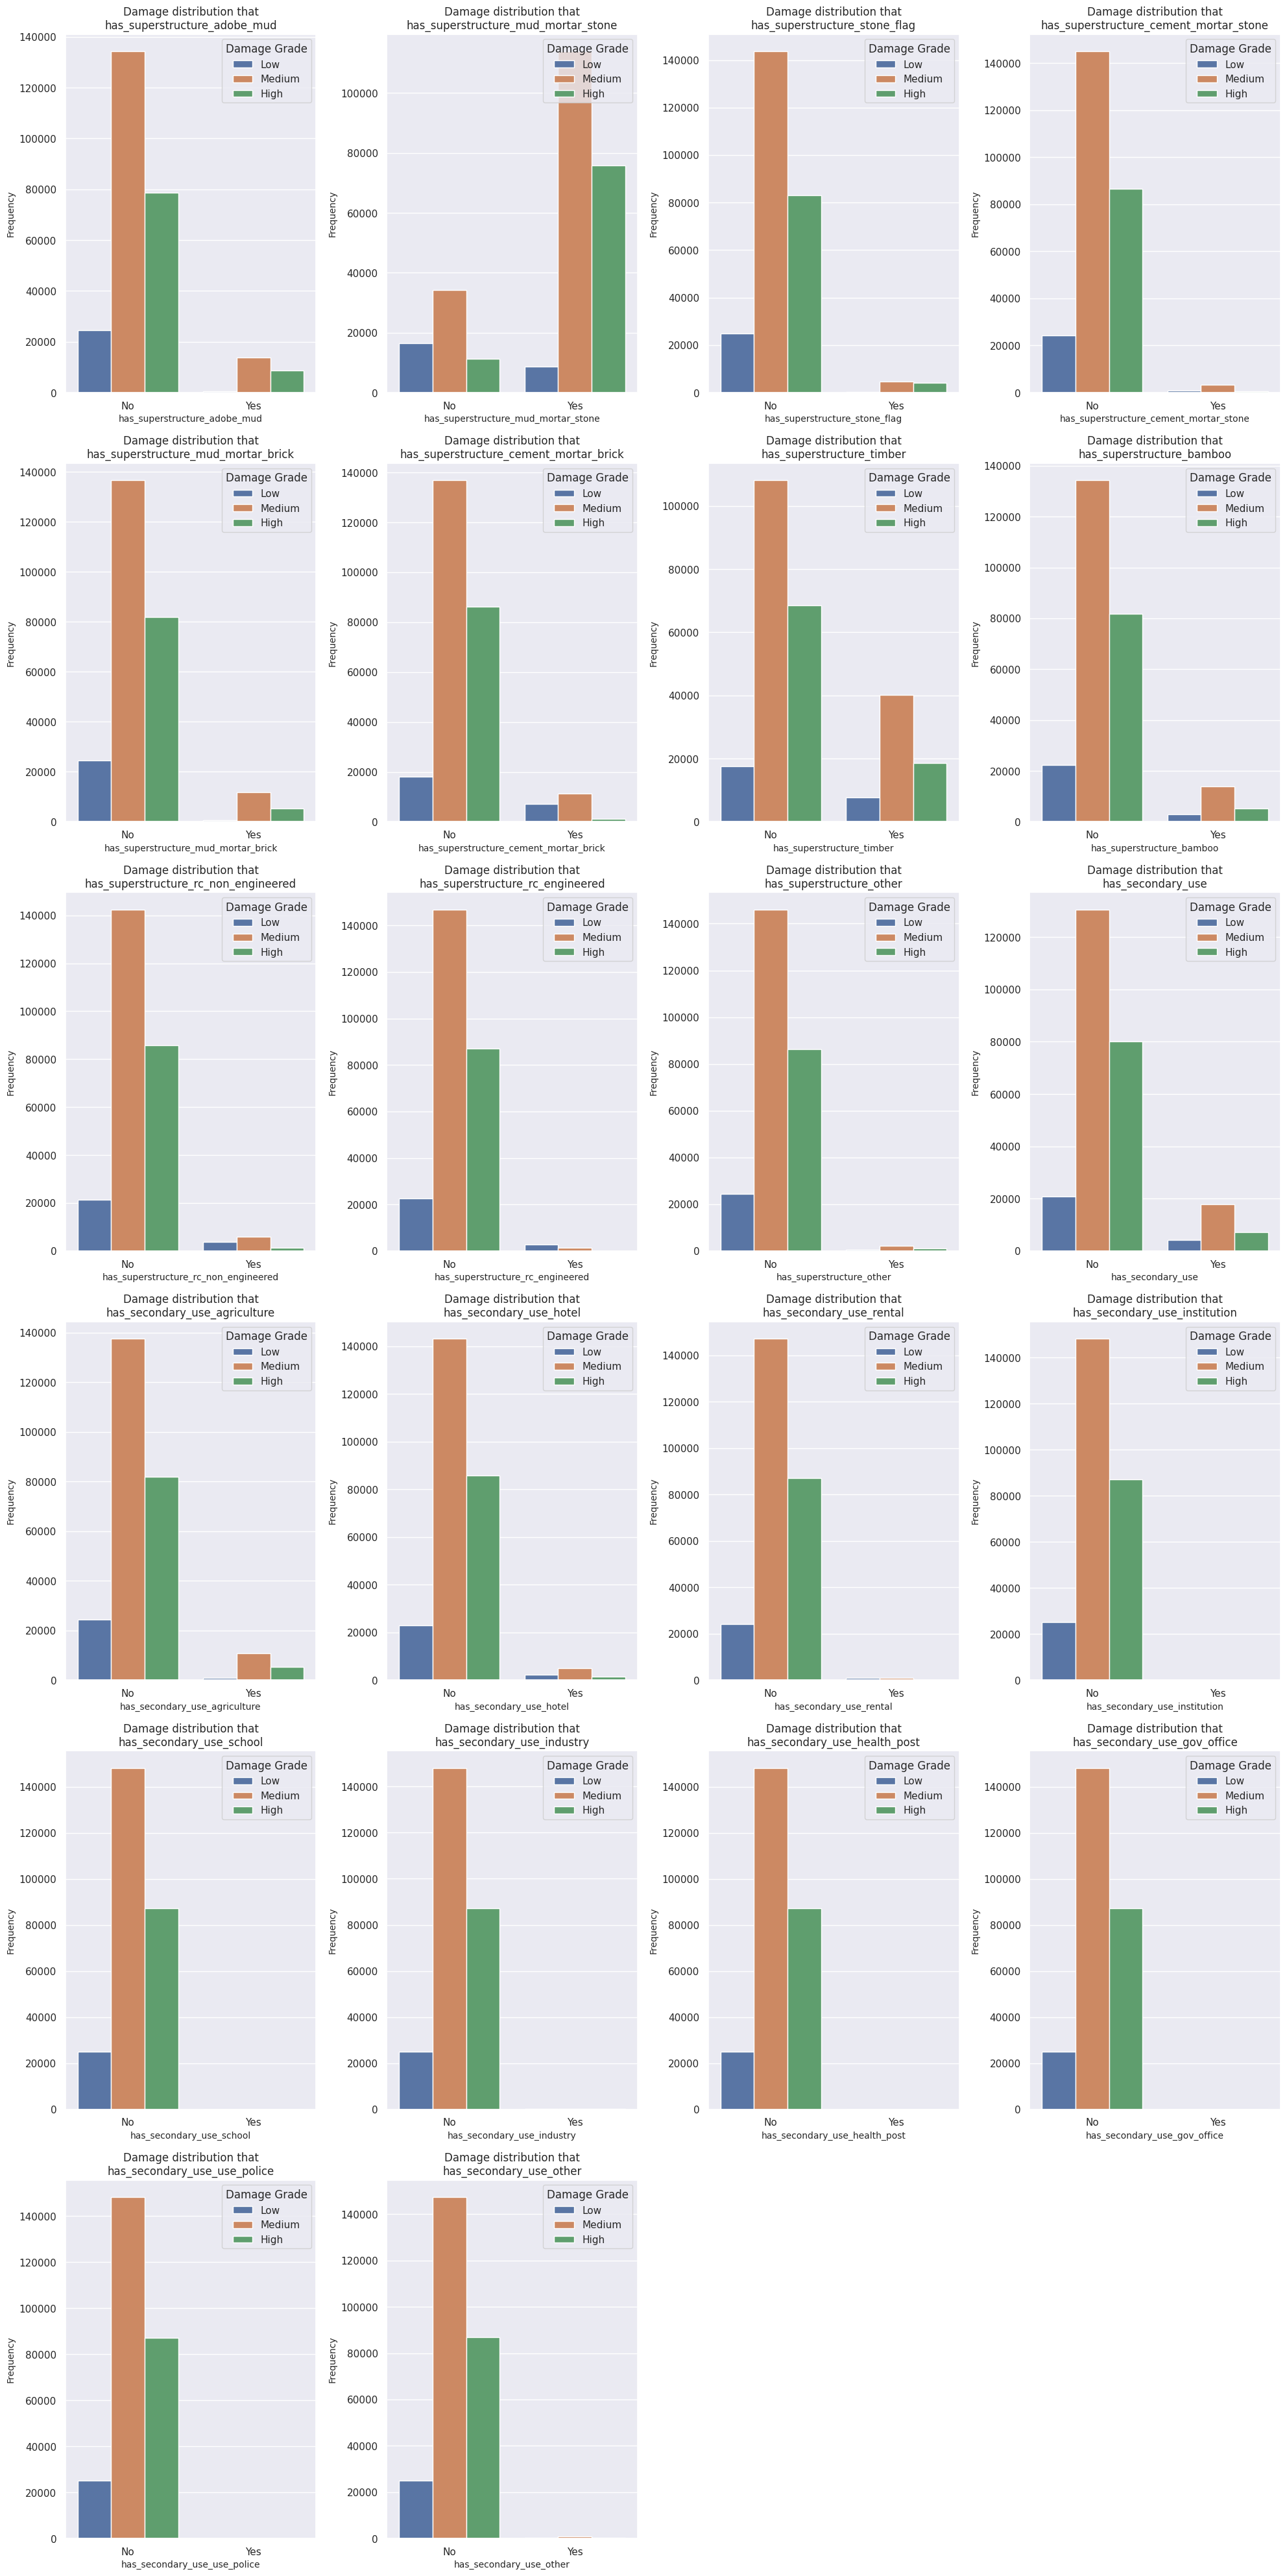

In [65]:
fig = plt.figure(figsize=(20, 46))

binary_col = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
              'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
              'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick',
              'has_superstructure_timber', 'has_superstructure_bamboo',
              'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered',
              'has_superstructure_other', 'has_secondary_use',
              'has_secondary_use_agriculture', 'has_secondary_use_hotel',
              'has_secondary_use_rental', 'has_secondary_use_institution',
              'has_secondary_use_school', 'has_secondary_use_industry',
              'has_secondary_use_health_post', 'has_secondary_use_gov_office',
              'has_secondary_use_use_police', 'has_secondary_use_other']

for i in range(1, 23):
    plt.subplot(7, 4, i)
    sns.countplot(x=binary_col[i-1], data=train, hue='damage_grade', hue_order=['Low', 'Medium', 'High'])
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.xlabel(f'{binary_col[i-1]}', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'Damage distribution that\n{binary_col[i-1]}')
    plt.legend(title='Damage Grade', loc='upper right')

plt.tight_layout()
plt.show()


In buildings in Nepal, the superstructure that is widely used in buildings is a mixed superstructure of *Mud Mortar Stone* or a superstructure of *Timber*. Most buildings that use superstructures experience medium levels of damage, followed by high levels of damage. Apart from buildings for private purposes, many buildings in Nepal are used for agricultural purposes, hotels, rentals, institutions, schools, health posts, government offices, police stations and other purposes. Buildings that have secondary purposes as agricultural facilities and hotels are the two sectors with the largest number of buildings compared to buildings with other secondary purposes. Most buildings with secondary agricultural and hotel purposes suffered moderate levels of damage.

### Facetgrid

In [123]:
def facet_plot(data, col, x, x_label):
    grid = sns.FacetGrid(data, col=col, row='damage_grade', height=4, aspect=2, sharey=False)
    grid.map(plt.hist, x, bins=20)
    grid.set_xlabels(x_label)
    grid.set_ylabels('Frequency')
    plt.show()

#### Superstructure RC, non RC, Mud Mortar Stone, Mud Mortar Brick, Cement Mortar Brick and Number of Floor

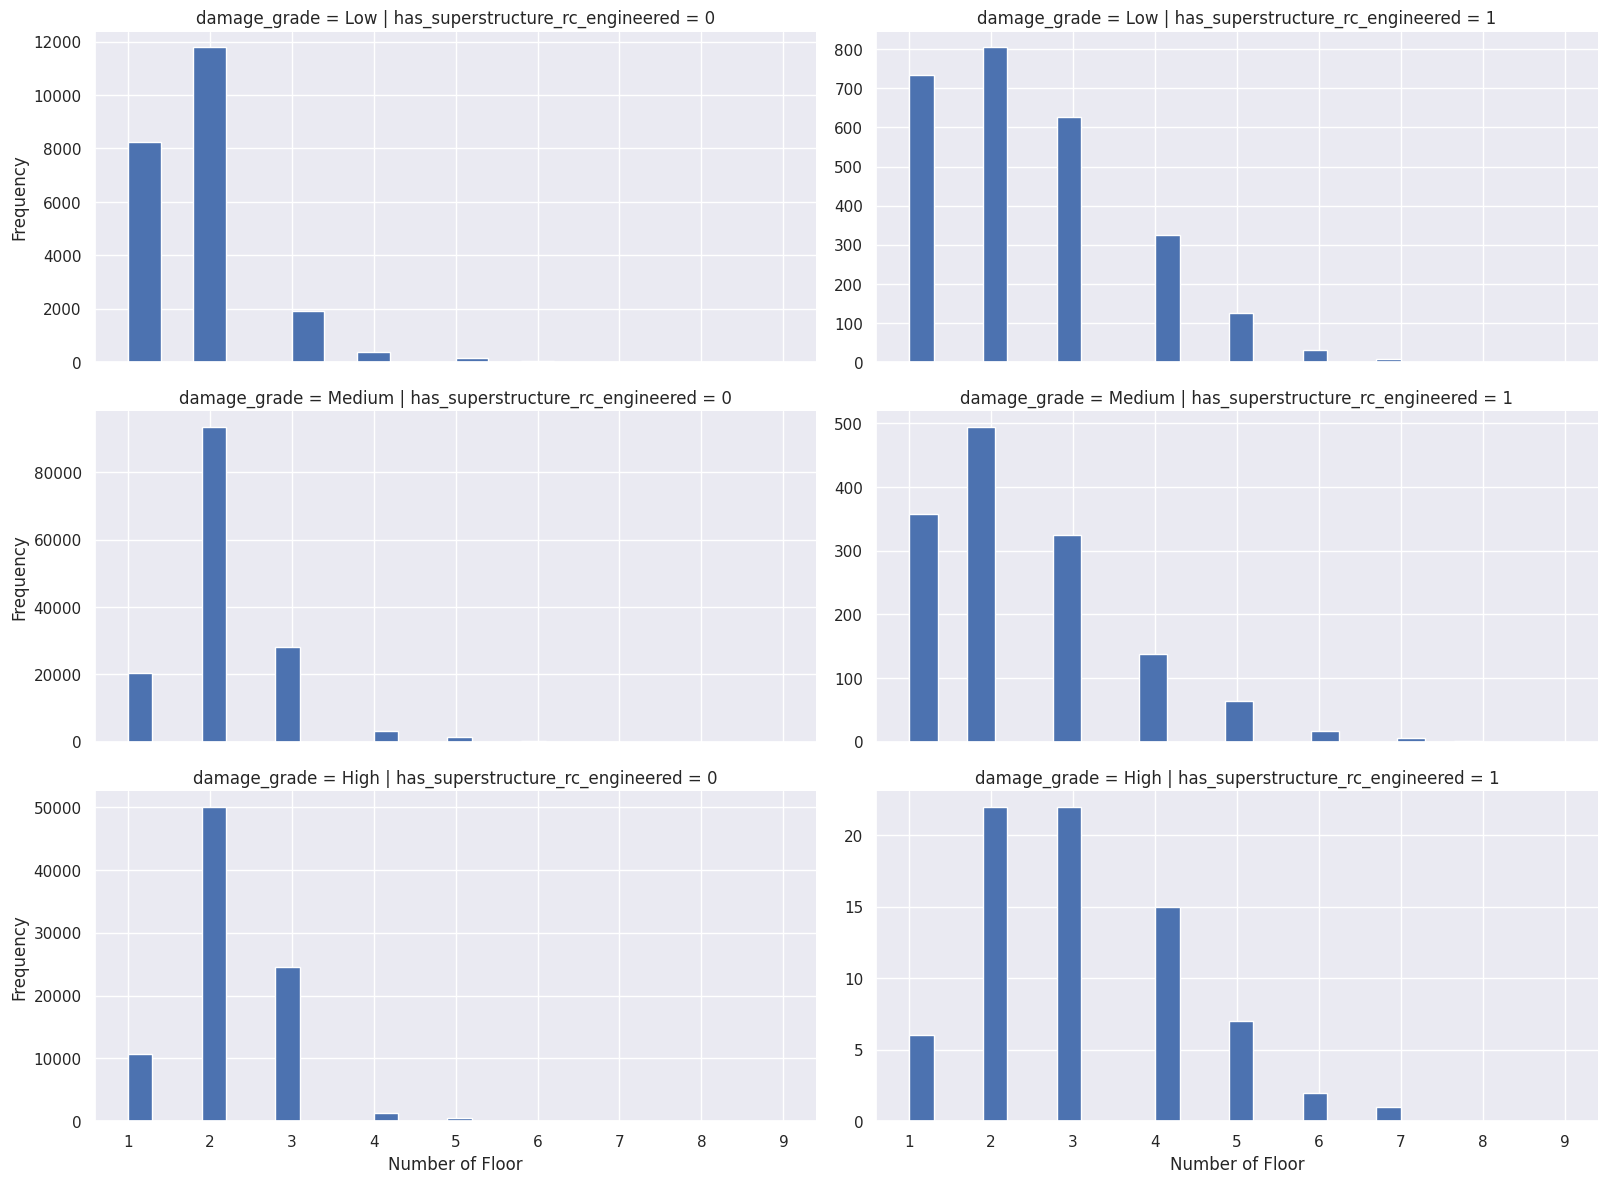

In [124]:
facet_plot(train, 'has_superstructure_rc_engineered', 'count_floors_pre_eq', 'Number of Floor')

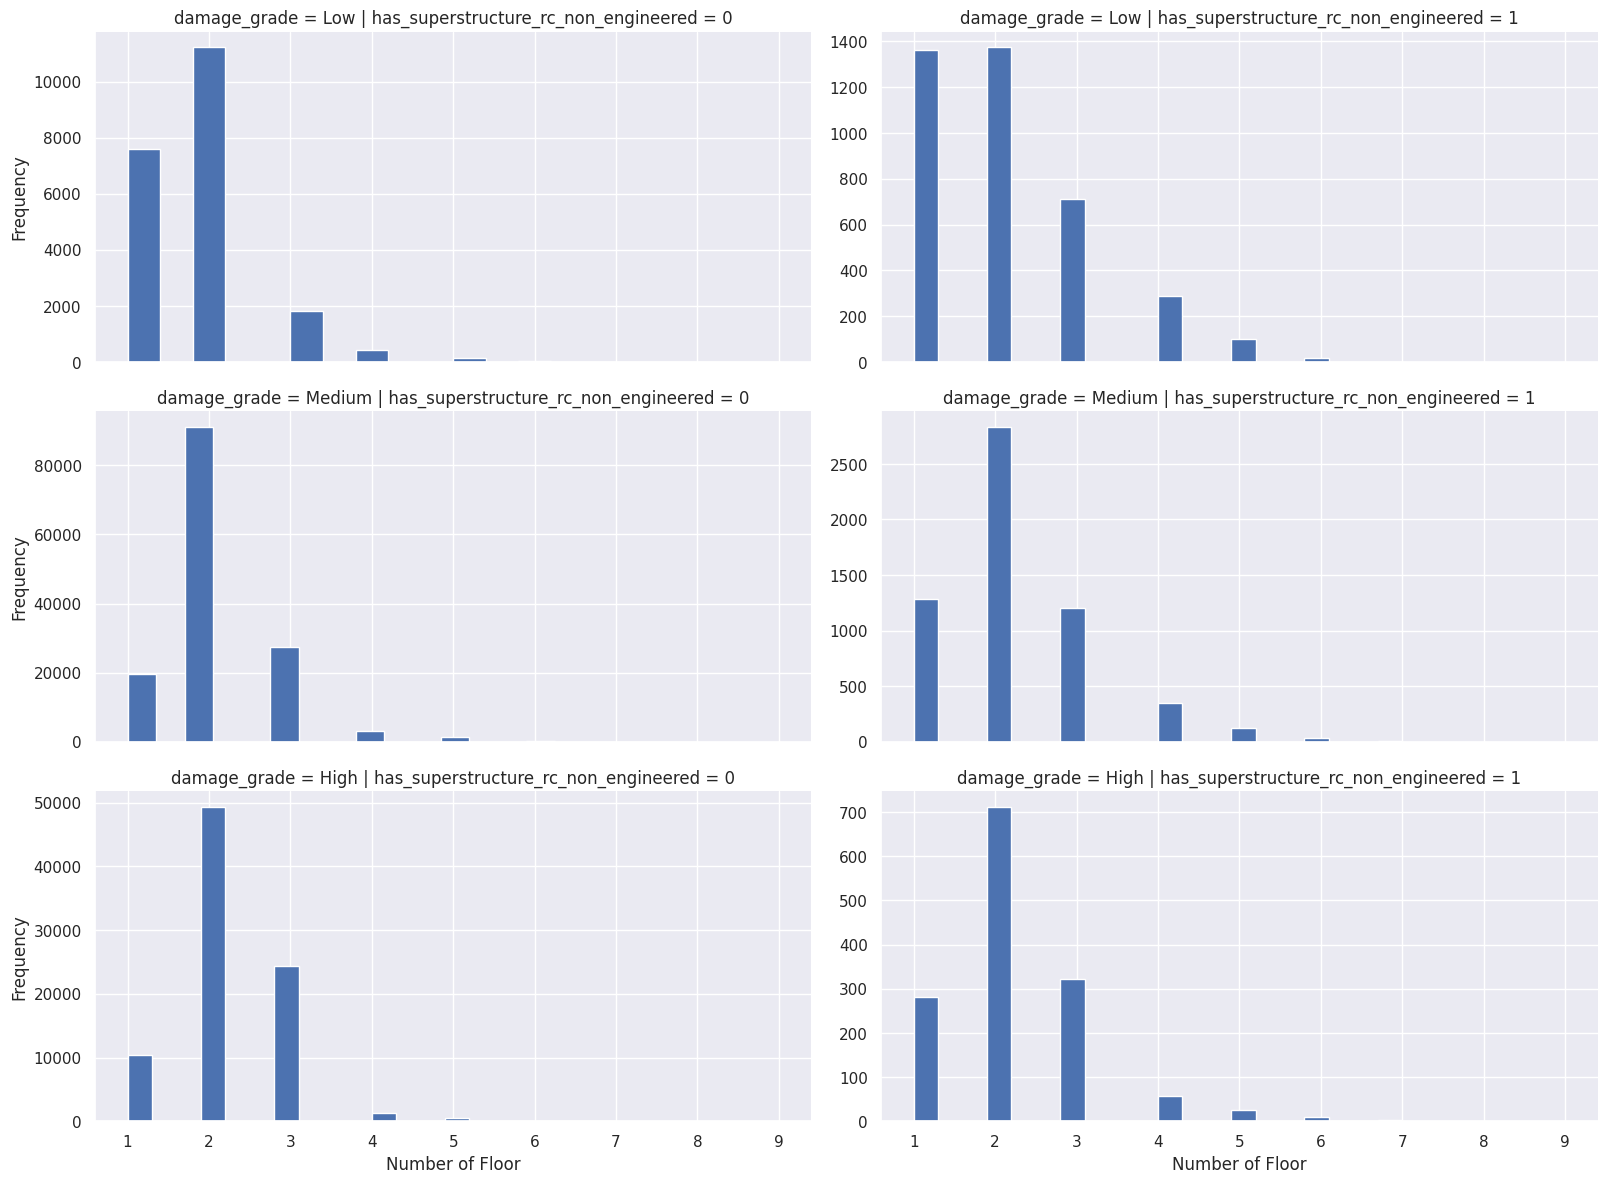

In [125]:
facet_plot(train, 'has_superstructure_rc_non_engineered', 'count_floors_pre_eq', 'Number of Floor')

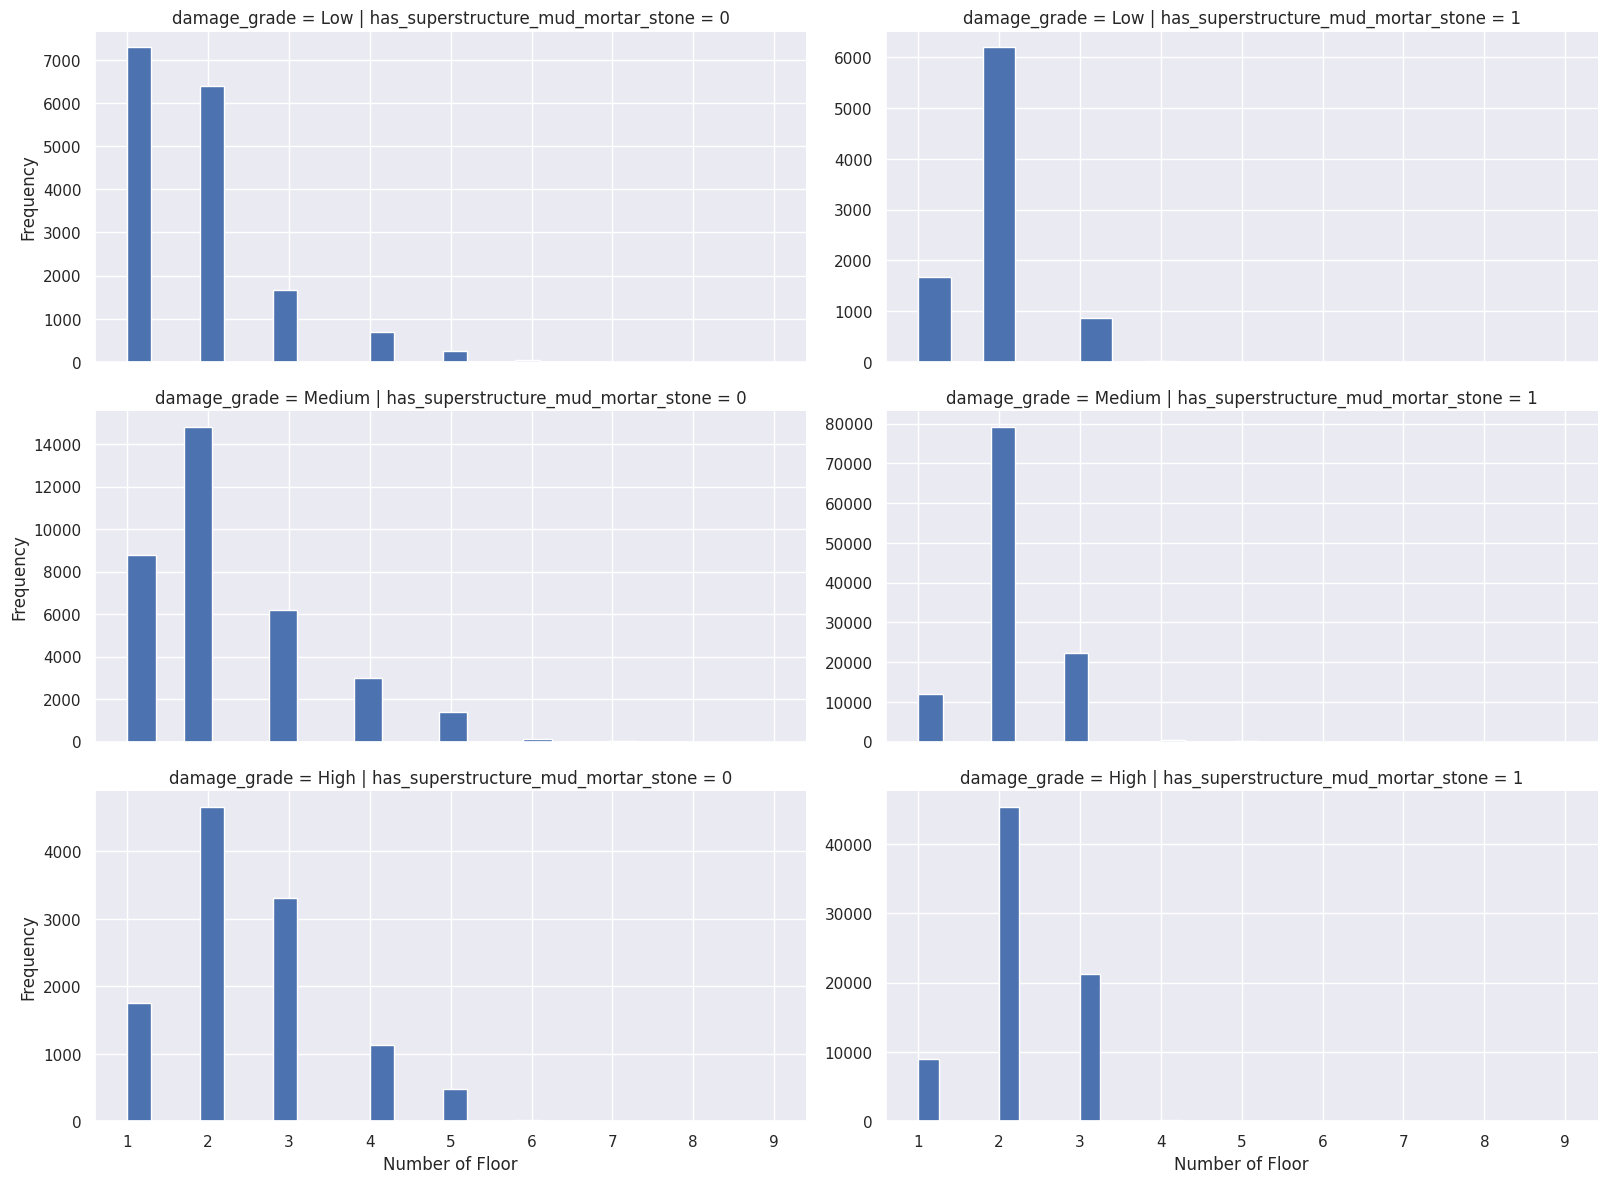

In [126]:
facet_plot(train, 'has_superstructure_mud_mortar_stone', 'count_floors_pre_eq', 'Number of Floor')

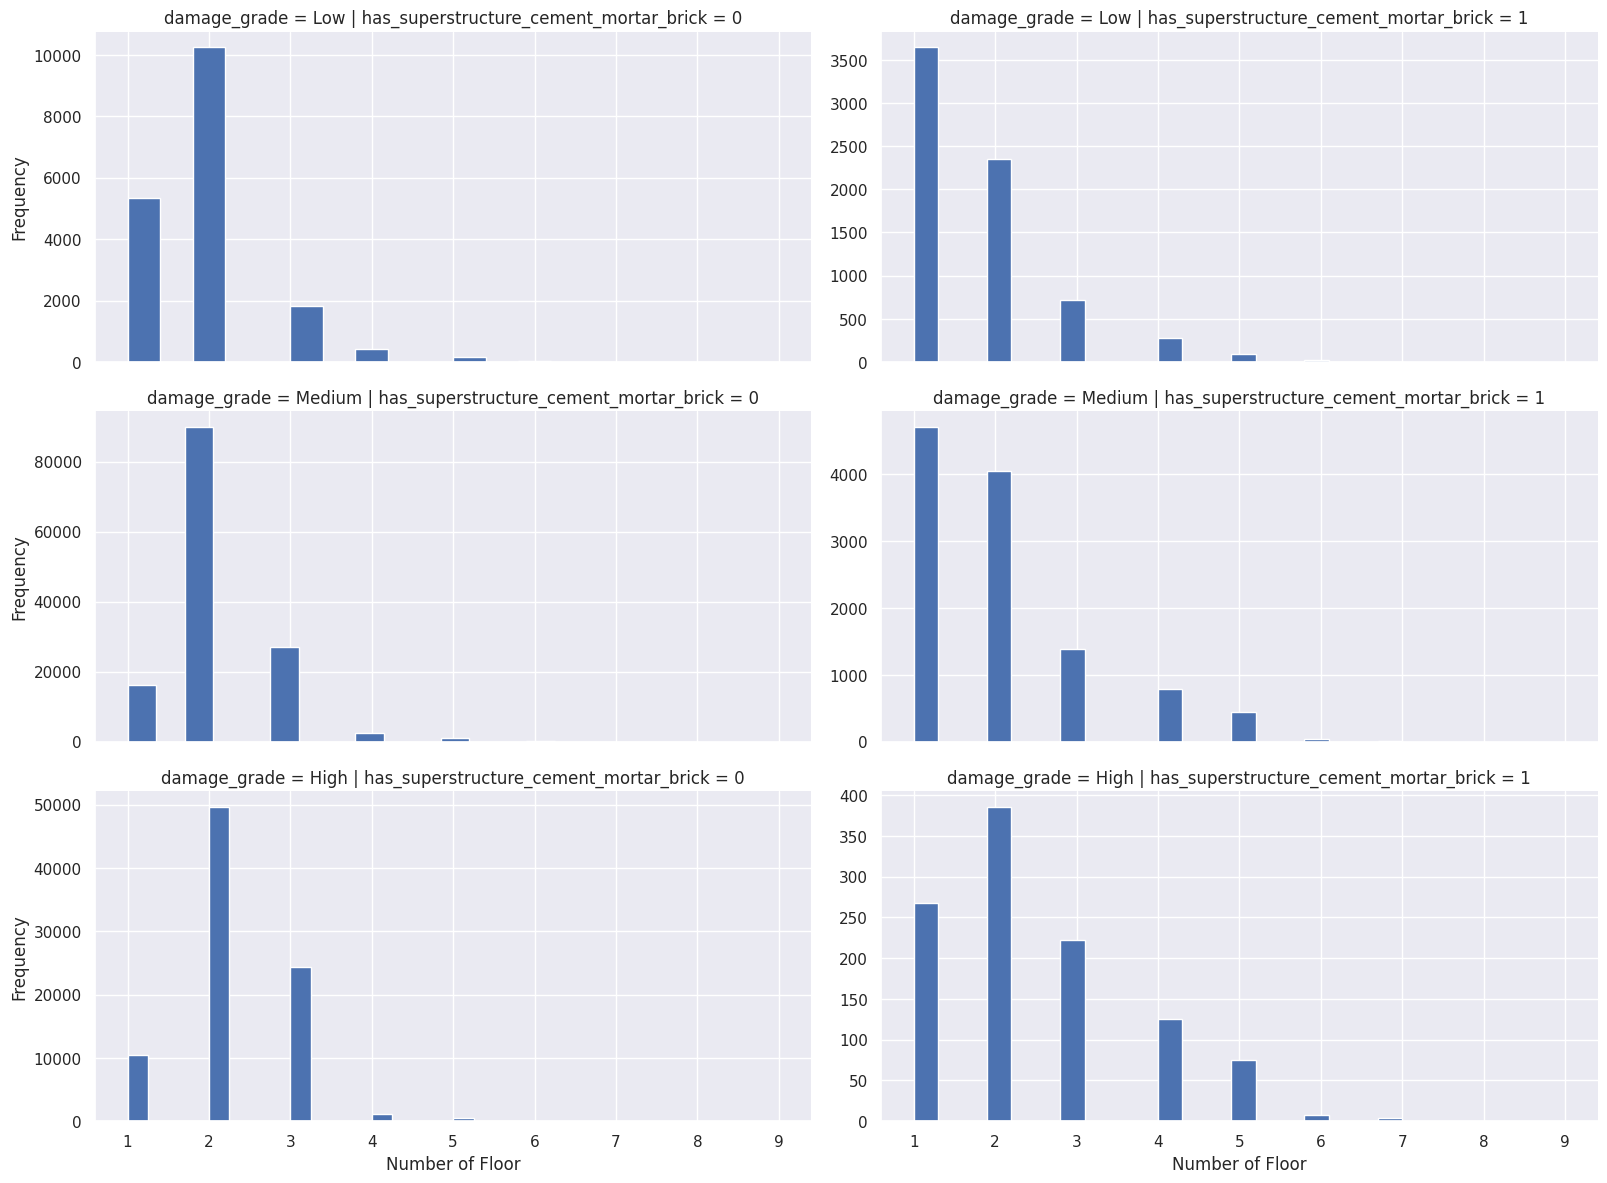

In [127]:
facet_plot(train, 'has_superstructure_cement_mortar_brick', 'count_floors_pre_eq', 'Number of Floor')

#### Superstructure RC, non RC, Mud Mortar Stone, Mud Mortar Brick, Cement Mortar Brick and Height Percentage

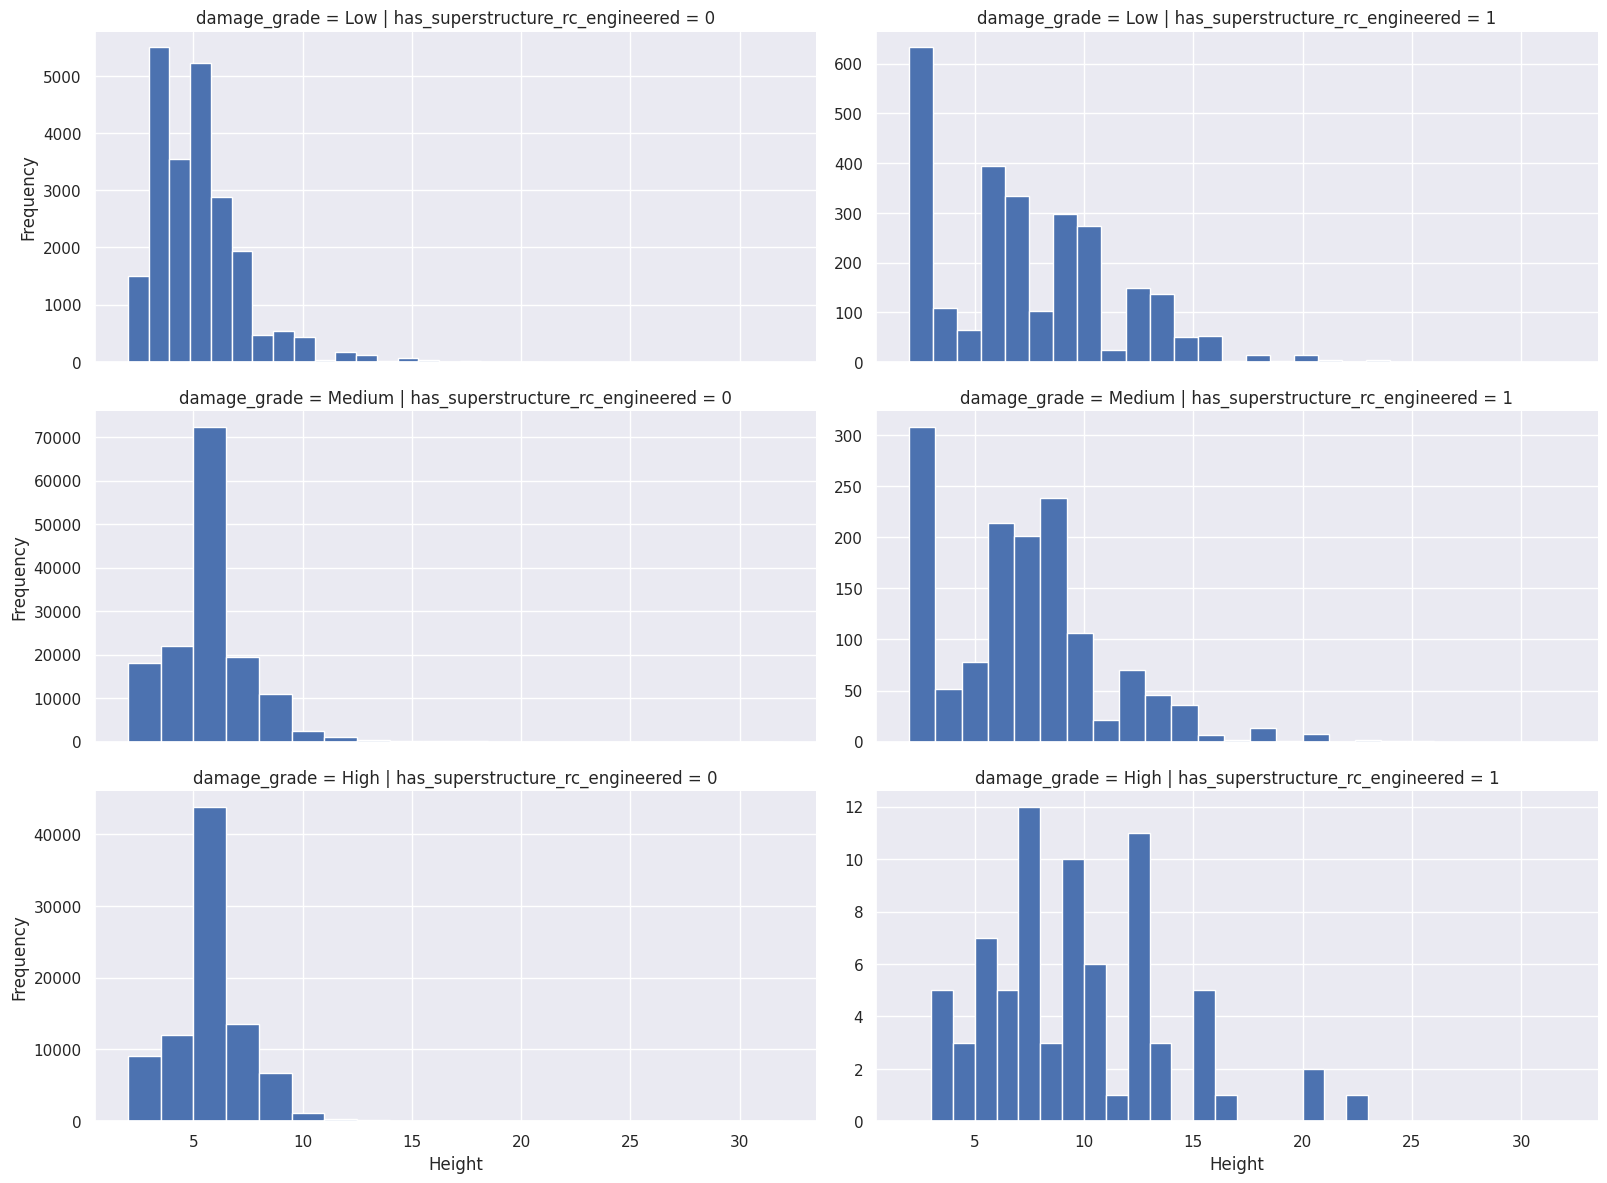

In [128]:
facet_plot(train, 'has_superstructure_rc_engineered', 'height_percentage', 'Height')

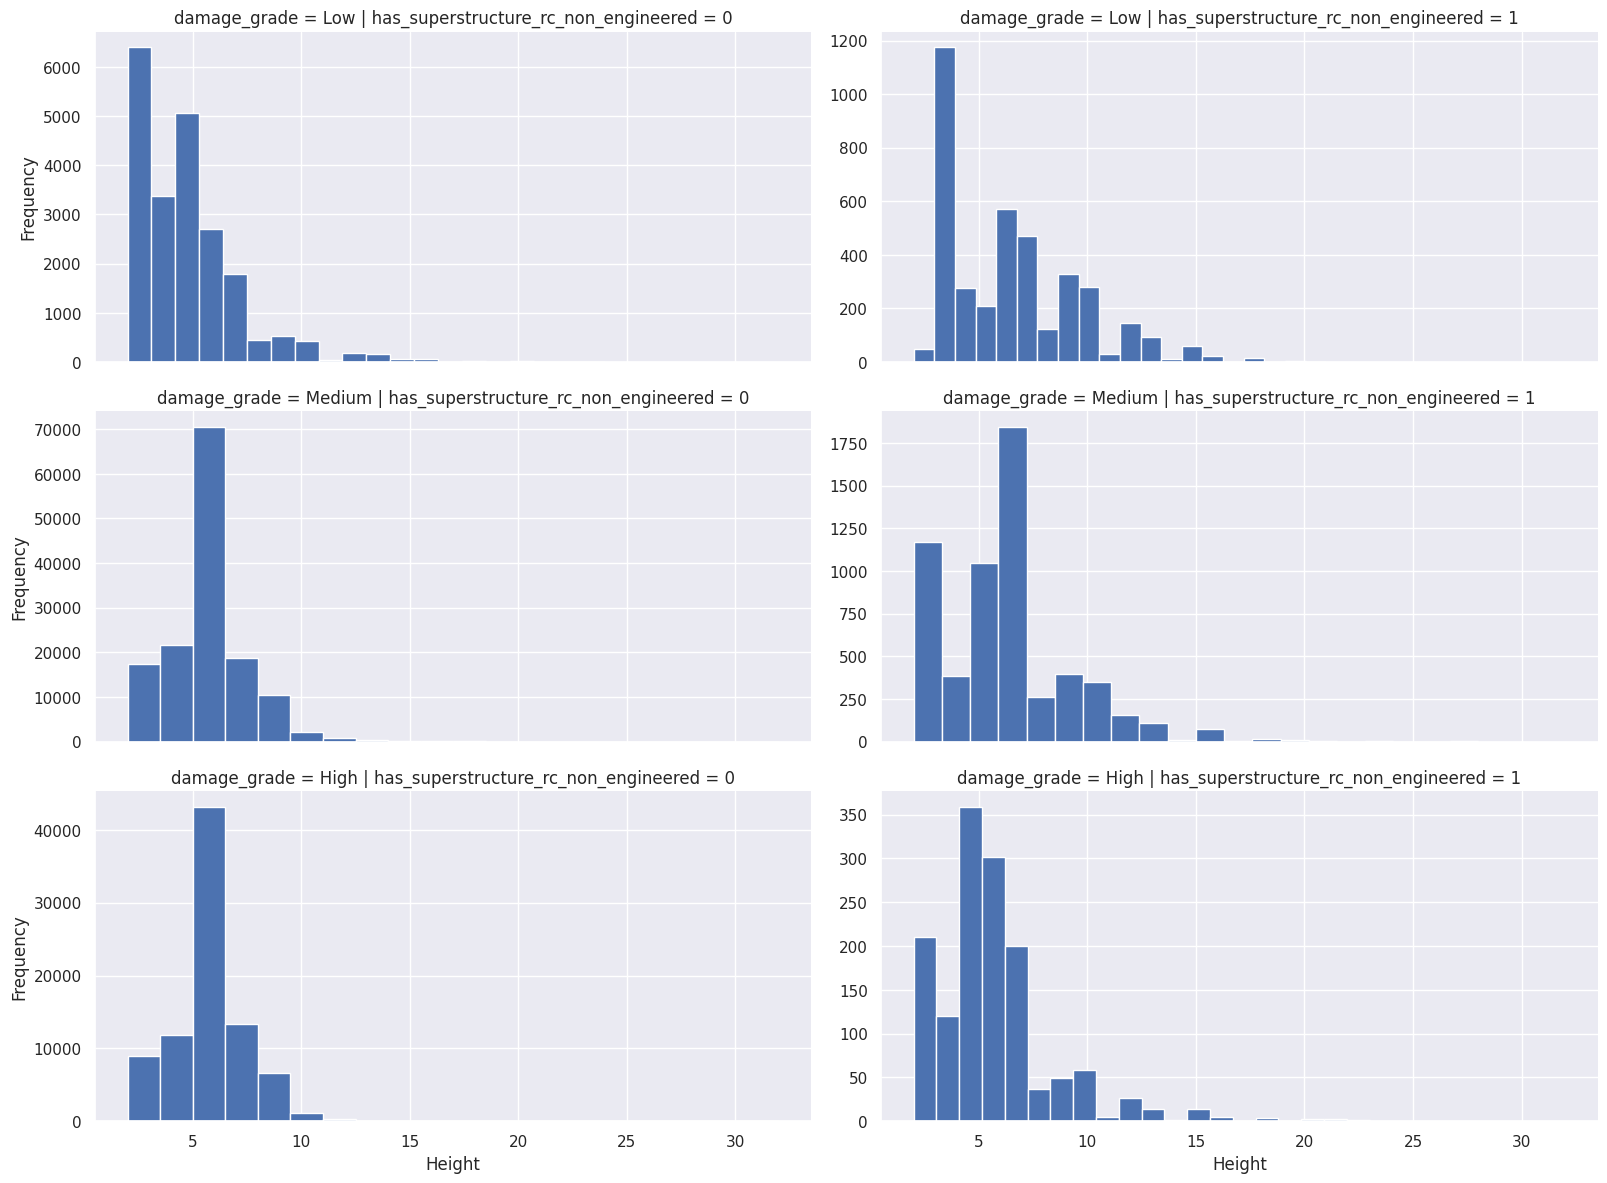

In [129]:
facet_plot(train, 'has_superstructure_rc_non_engineered', 'height_percentage', 'Height')

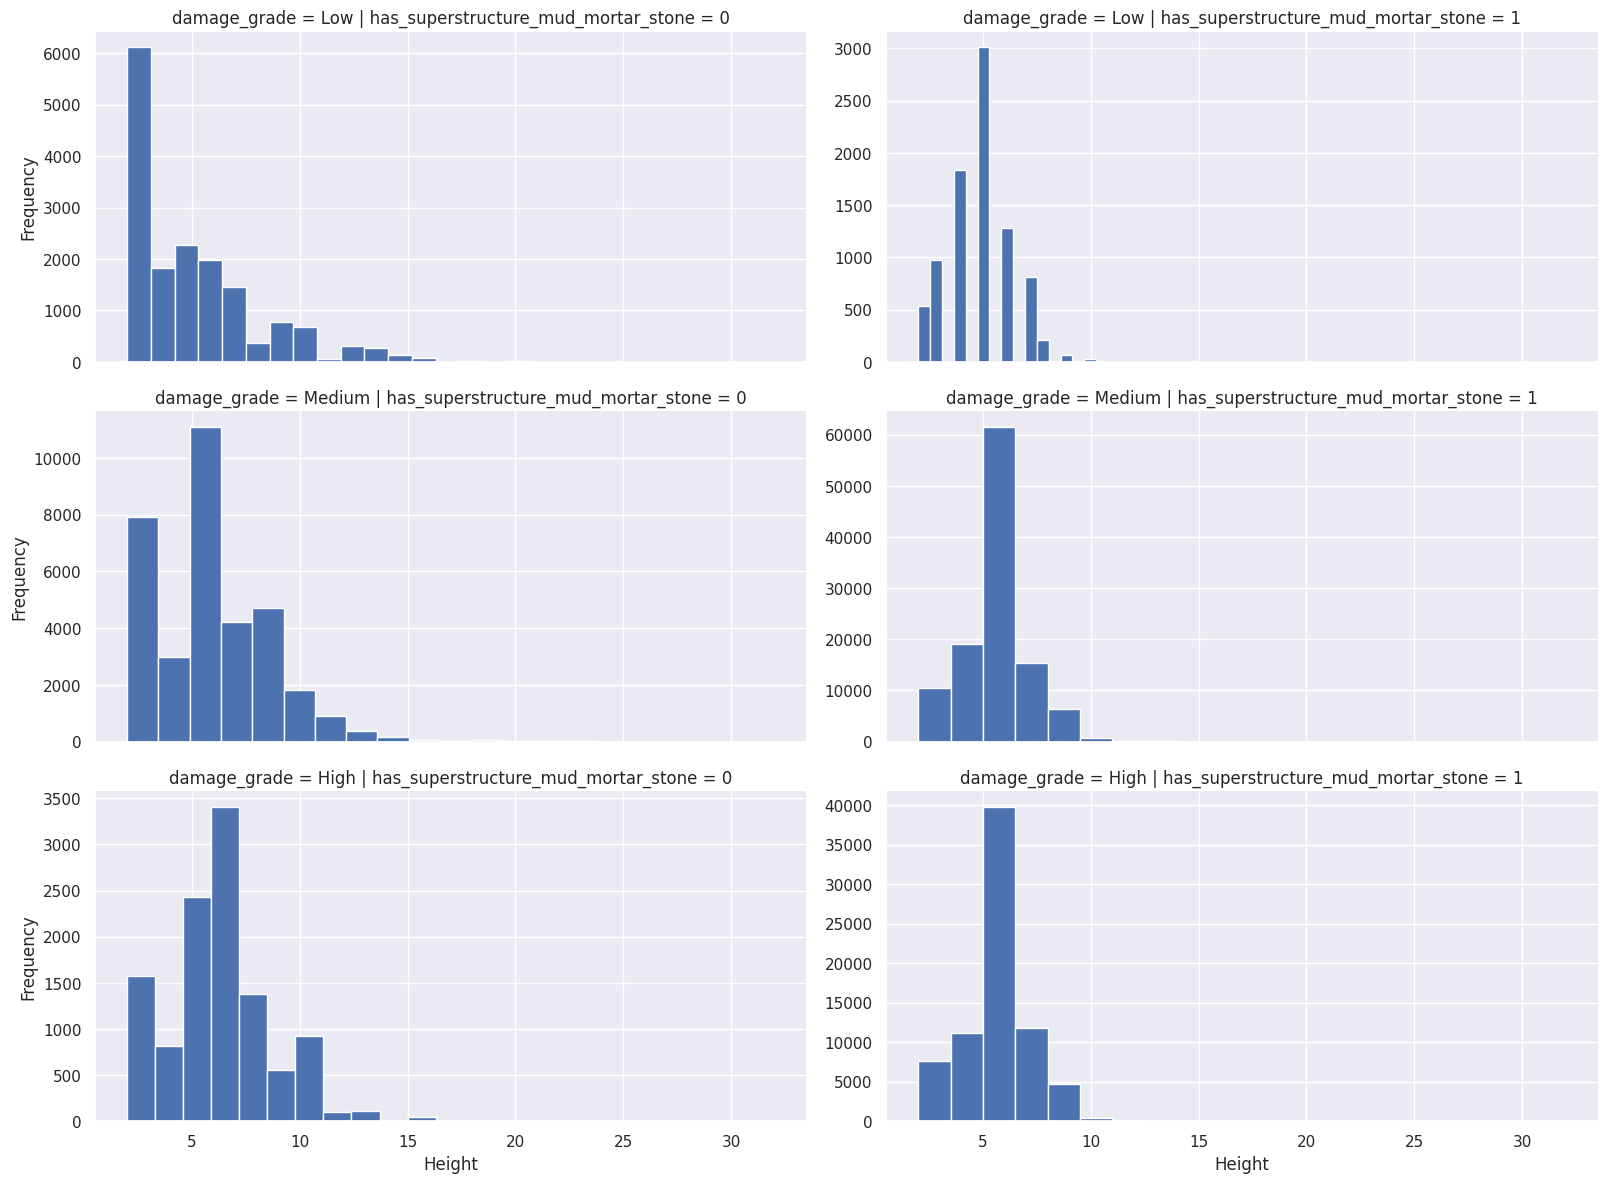

In [130]:
facet_plot(train, 'has_superstructure_mud_mortar_stone', 'height_percentage', 'Height')

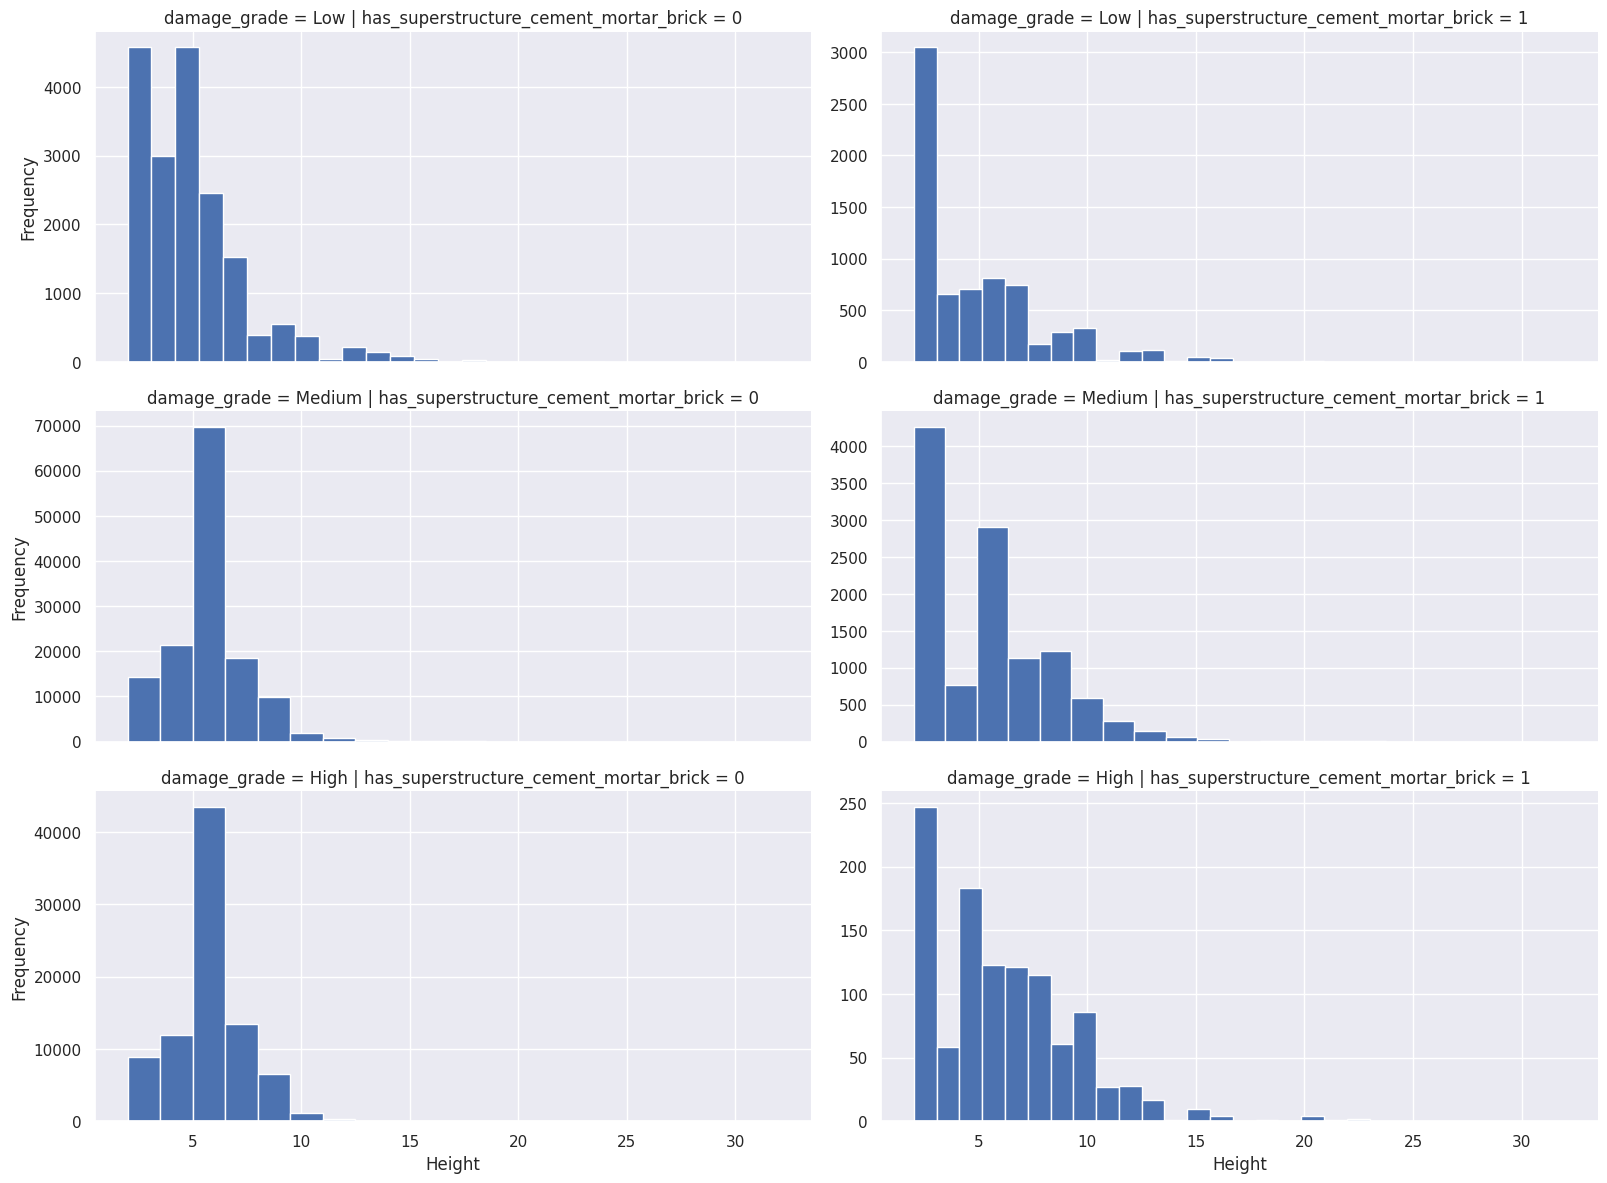

In [131]:
facet_plot(train, 'has_superstructure_cement_mortar_brick', 'height_percentage', 'Height')

#### Superstructure RC, non RC, Mud Mortar Stone, Mud Mortar Brick, Cement Mortar Brick and Area Percentage

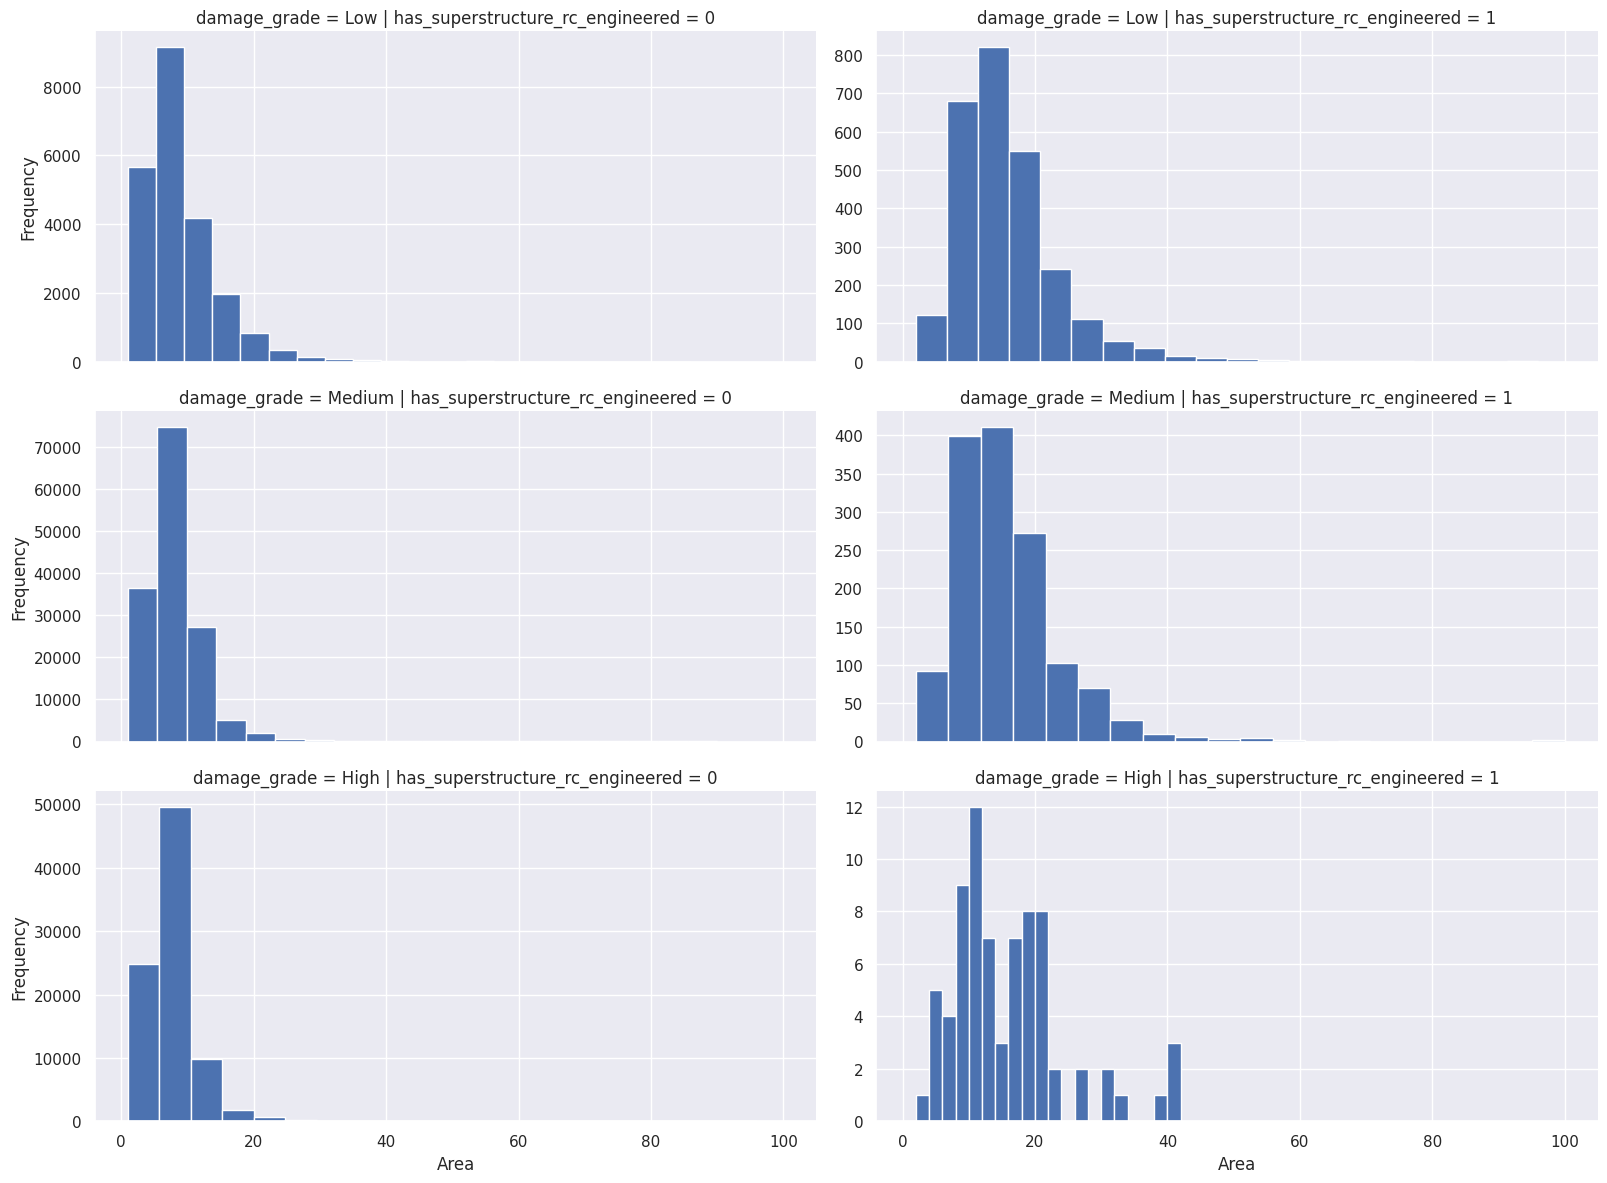

In [132]:
facet_plot(train, 'has_superstructure_rc_engineered', 'area_percentage', 'Area')

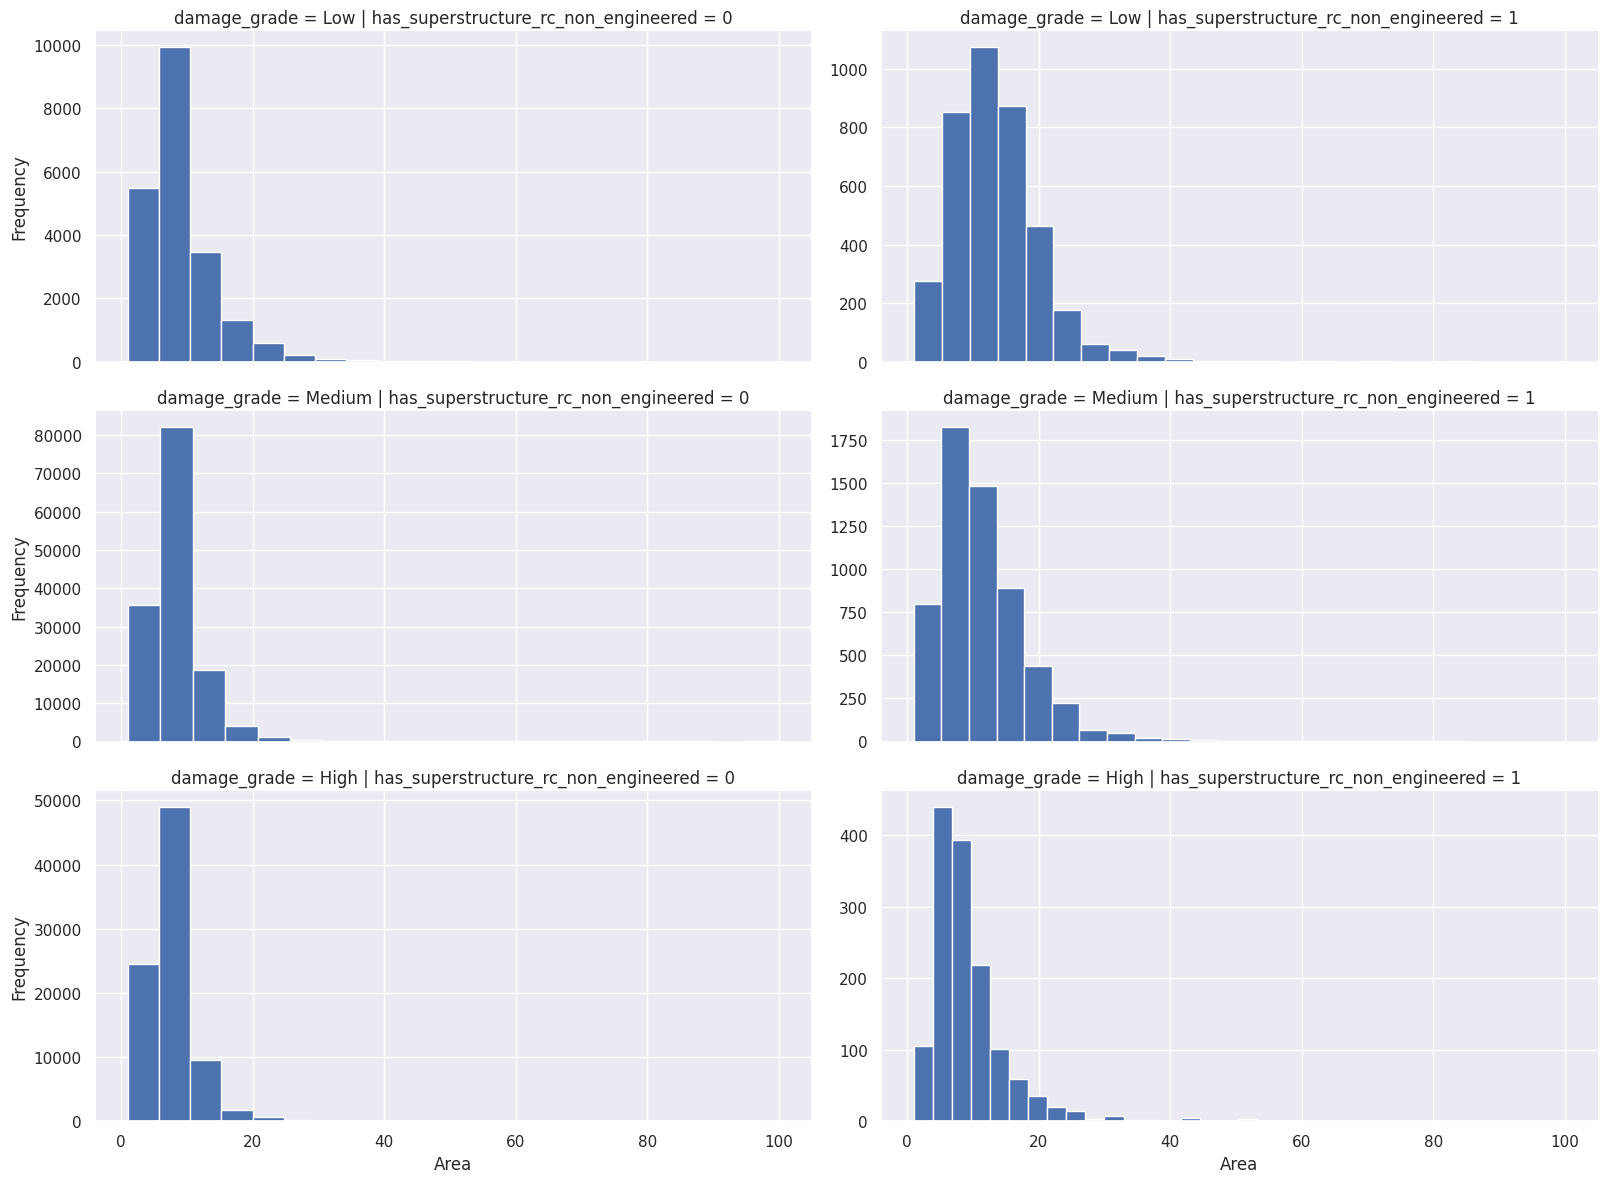

In [133]:
facet_plot(train, 'has_superstructure_rc_non_engineered', 'area_percentage', 'Area')

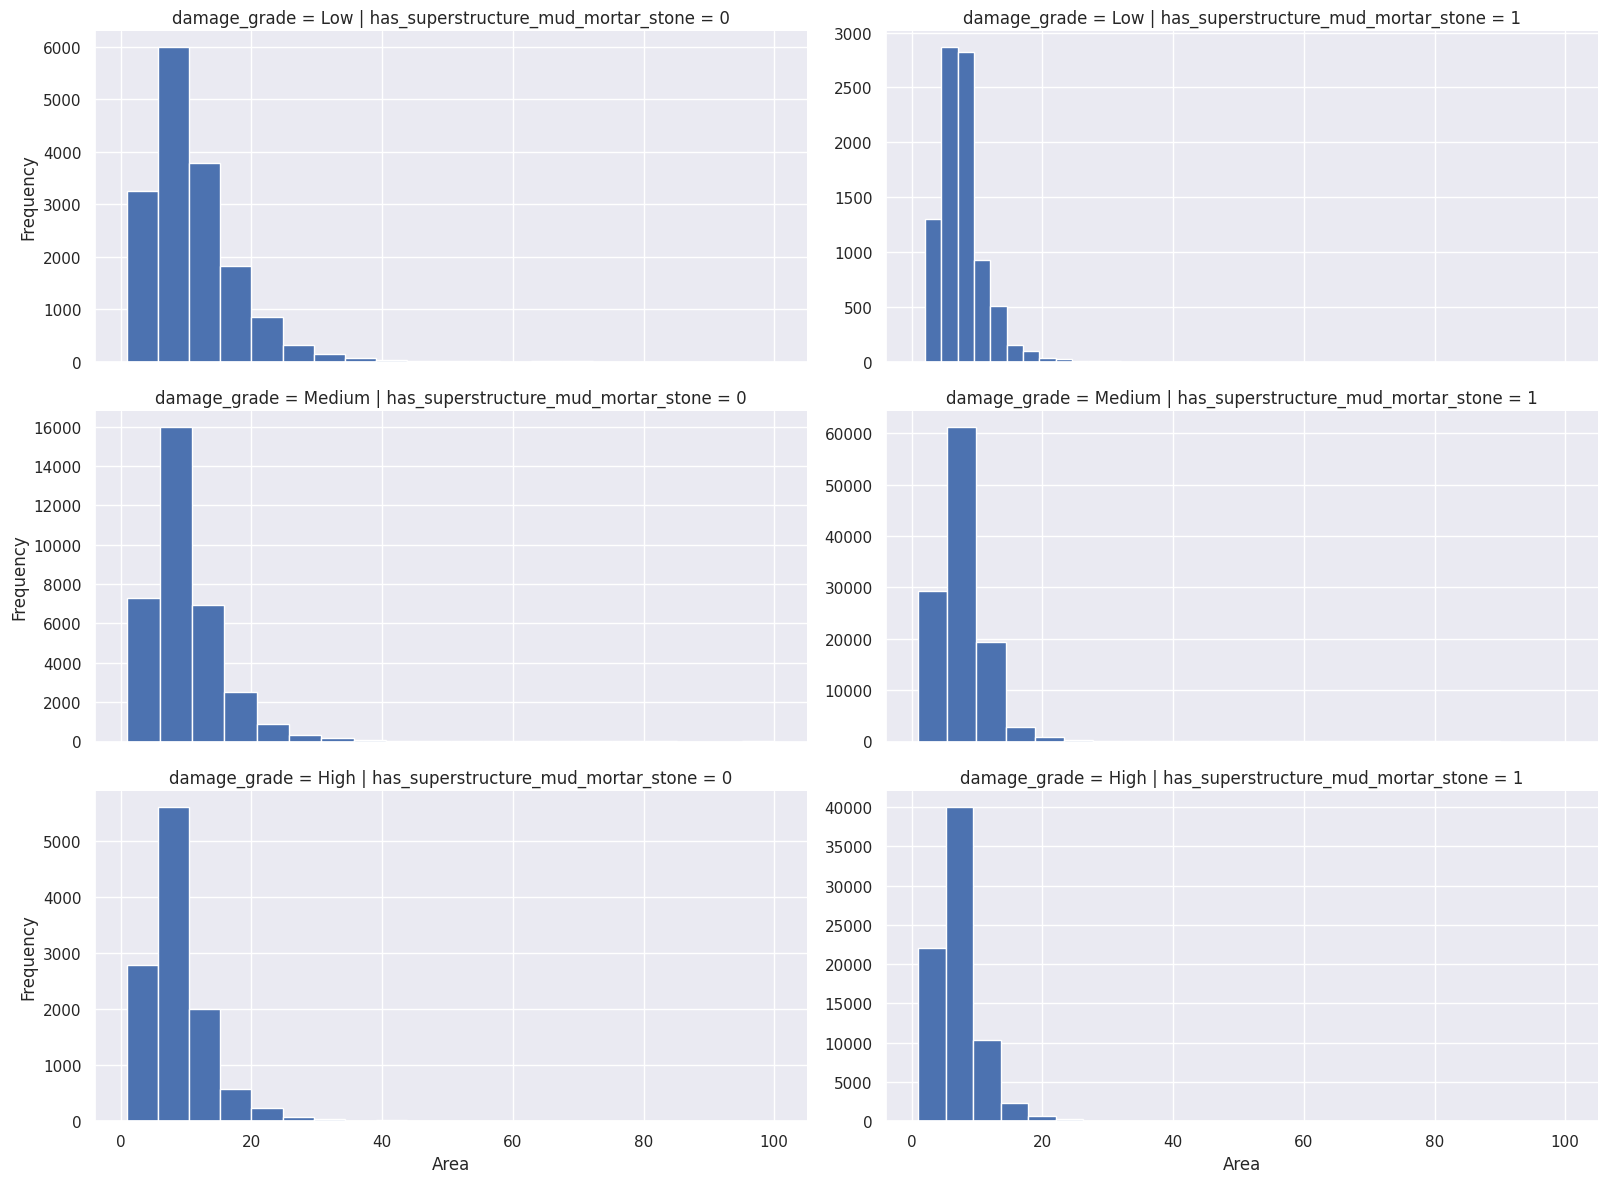

In [134]:
facet_plot(train, 'has_superstructure_mud_mortar_stone', 'area_percentage', 'Area')

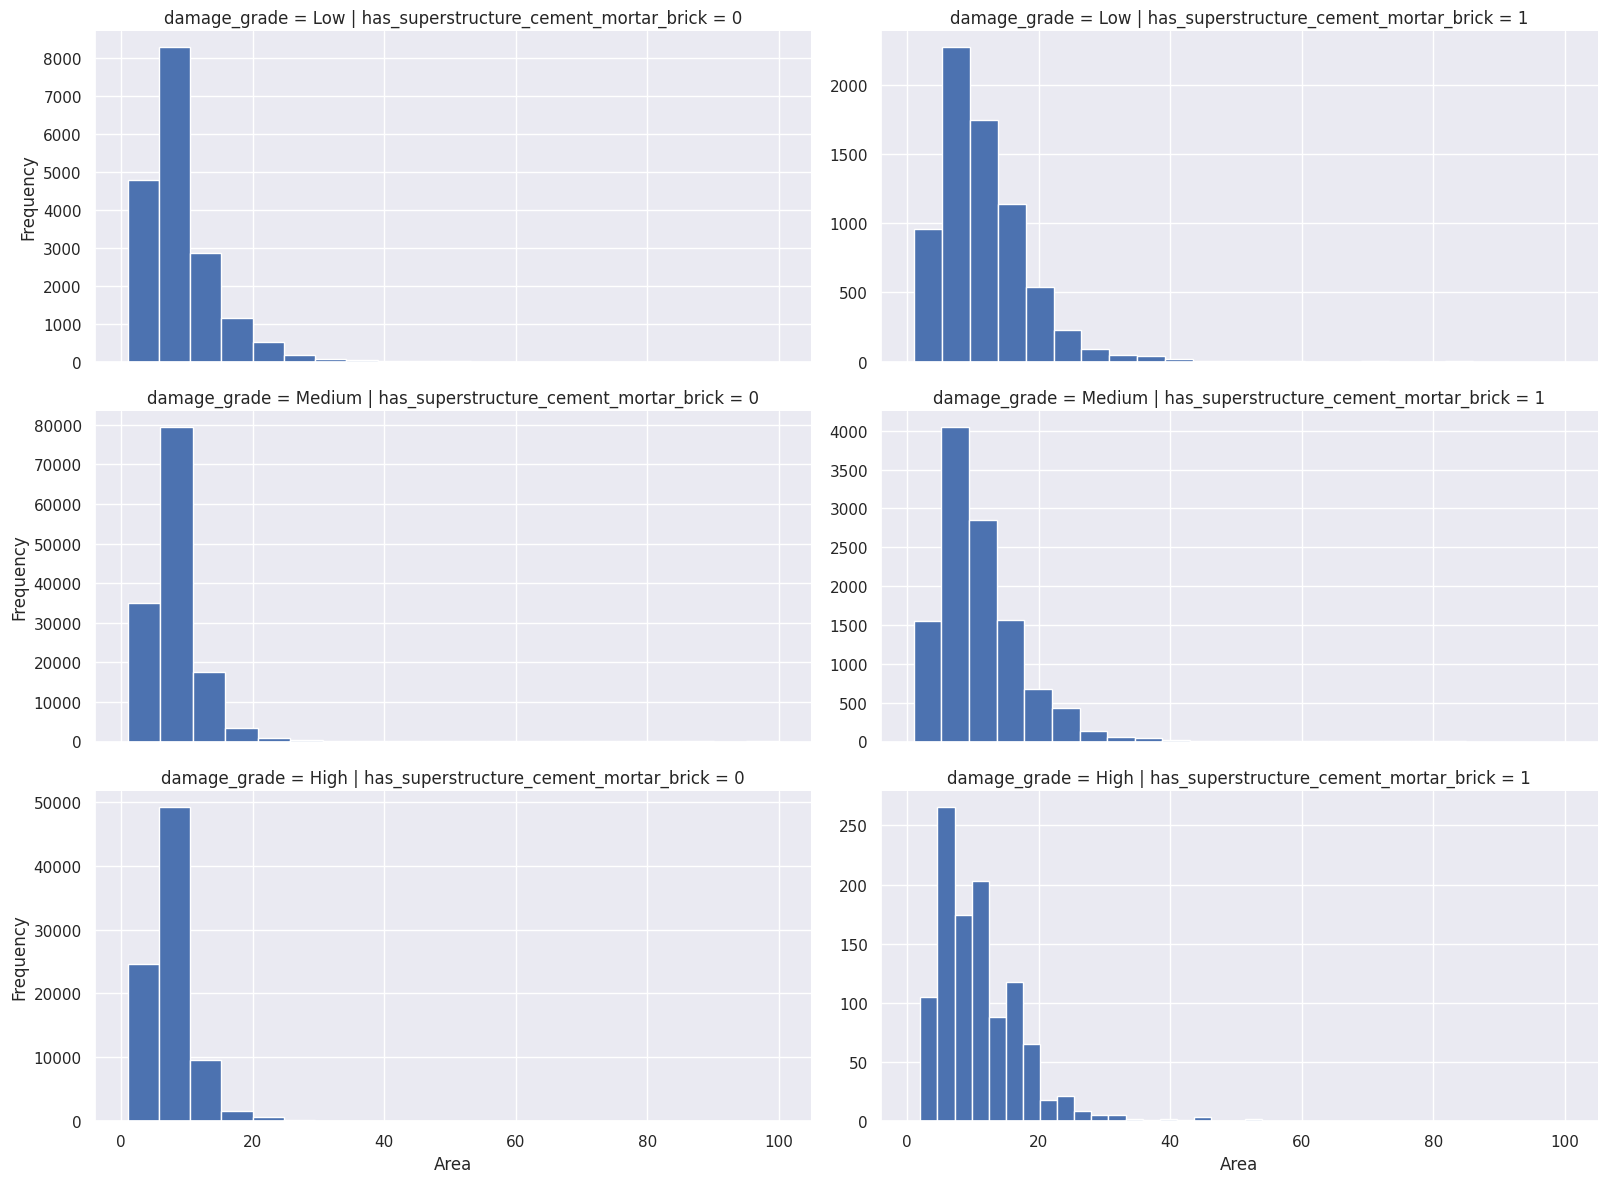

In [135]:
facet_plot(train, 'has_superstructure_cement_mortar_brick', 'area_percentage', 'Area')

### Multivariate Analysis

In [30]:
features = train.copy()
features['damage_grade'] = features['damage_grade'].replace({'Low':1, 'Medium':2, 'High':3})
features['damage_grade'] = features['damage_grade'].astype('int64')
corr_matrix = features.corr()

#### Correlation Matrix

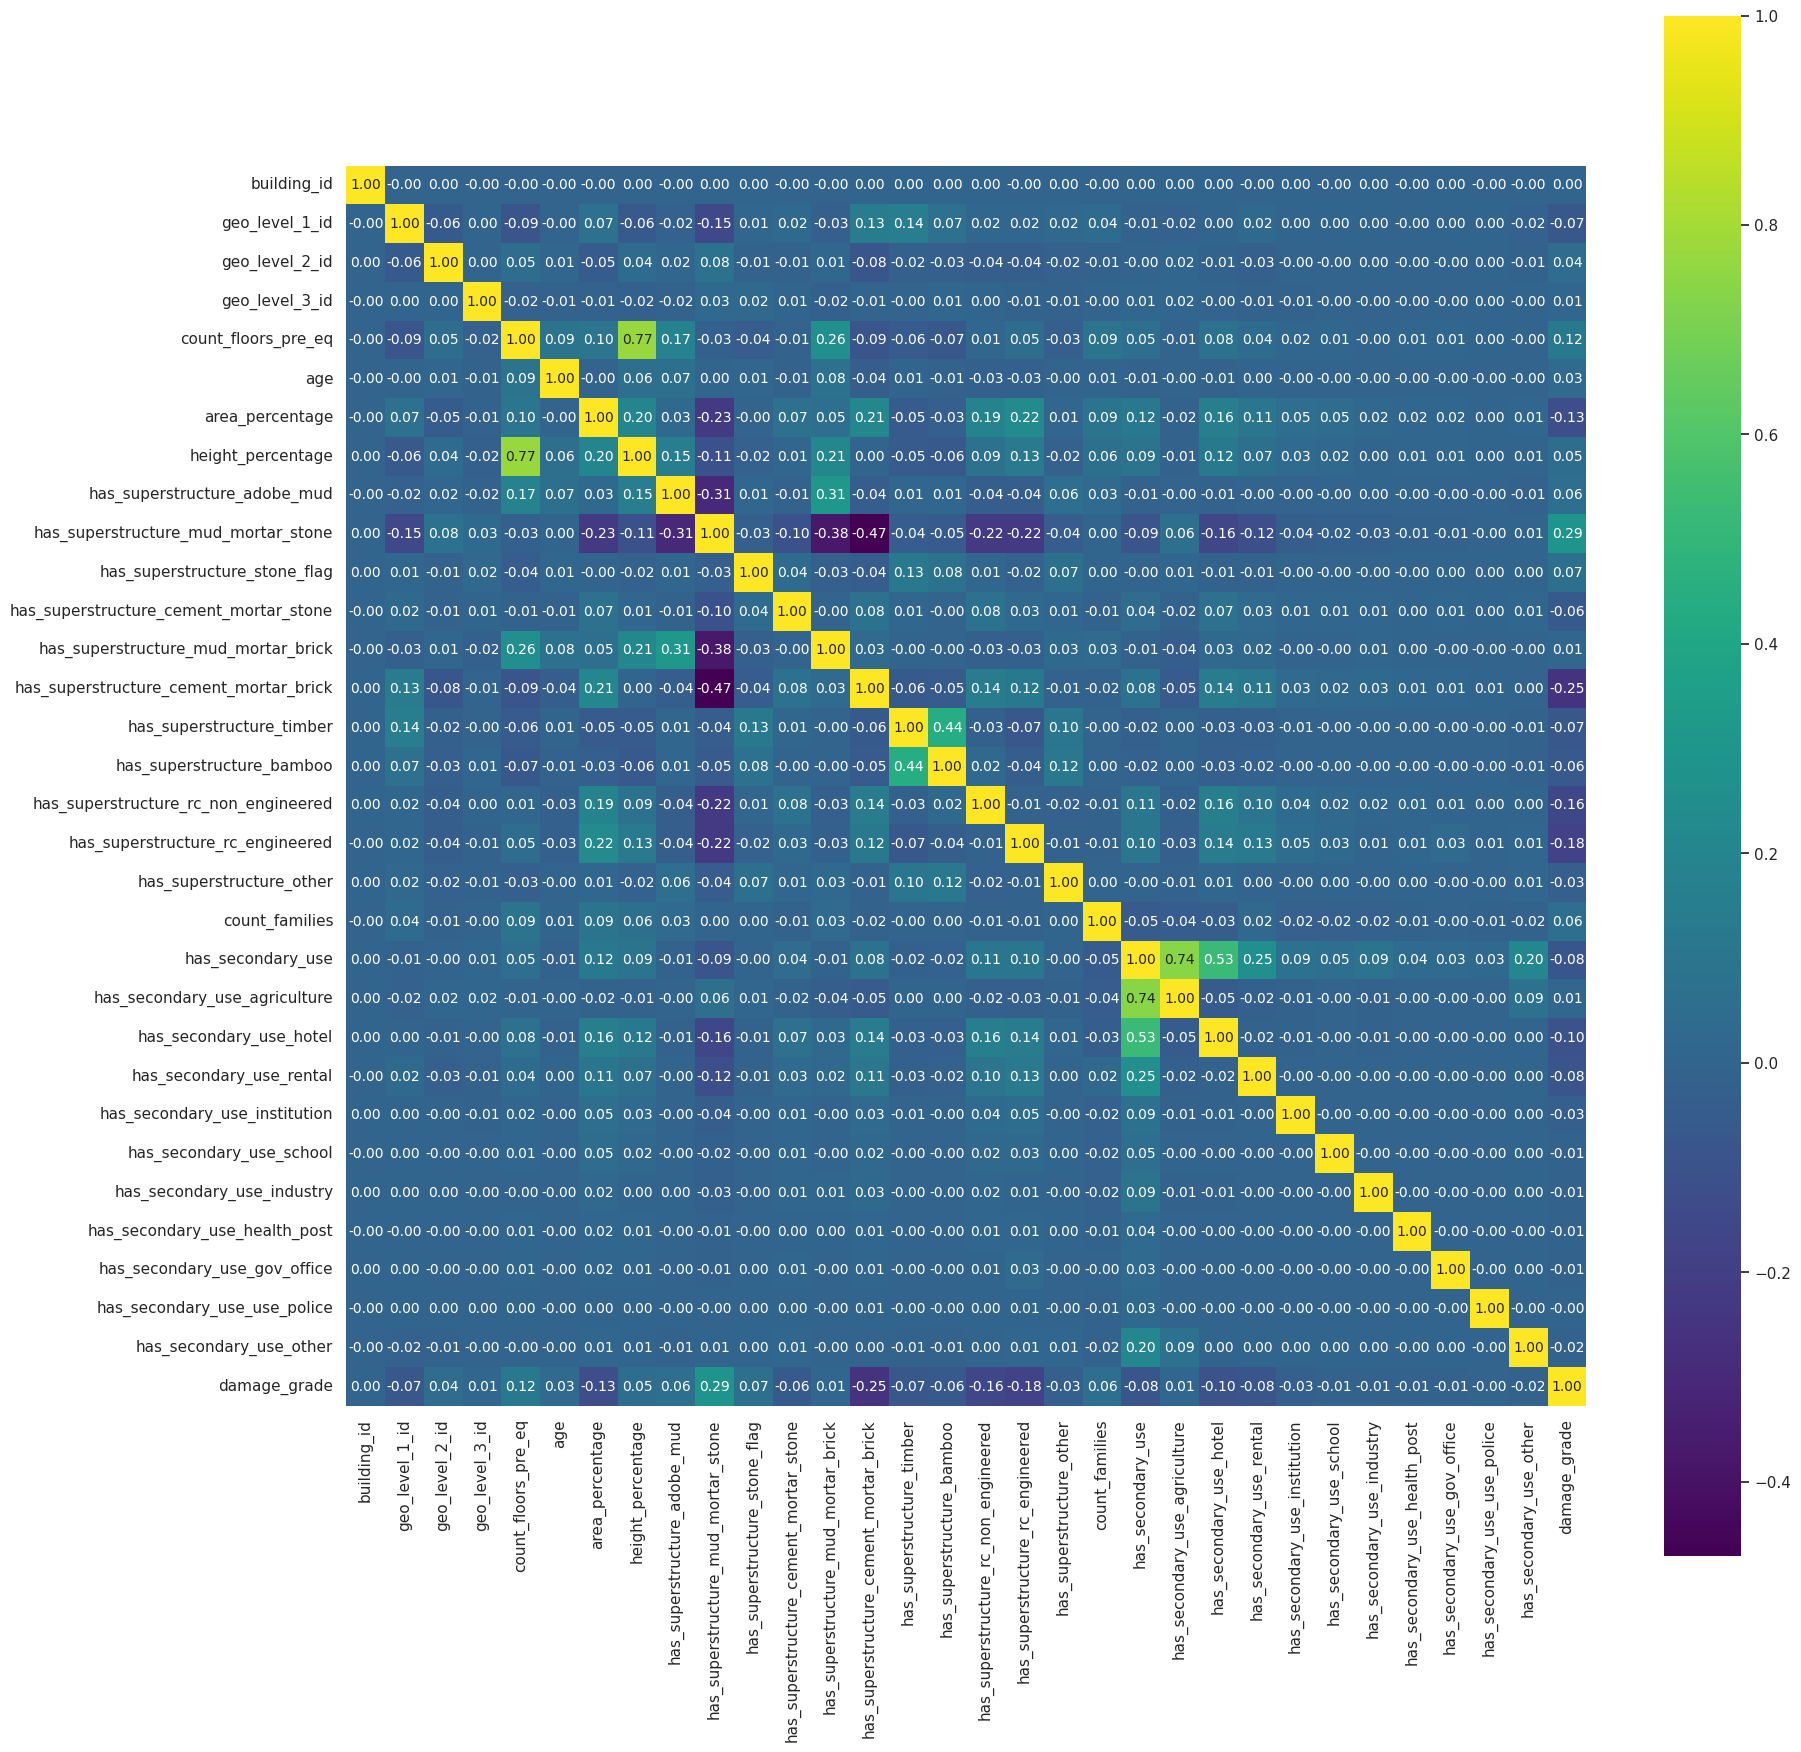

In [31]:
plt.figure(figsize=(20,20))

sns.heatmap(corr_matrix, annot=True, cmap='viridis', square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

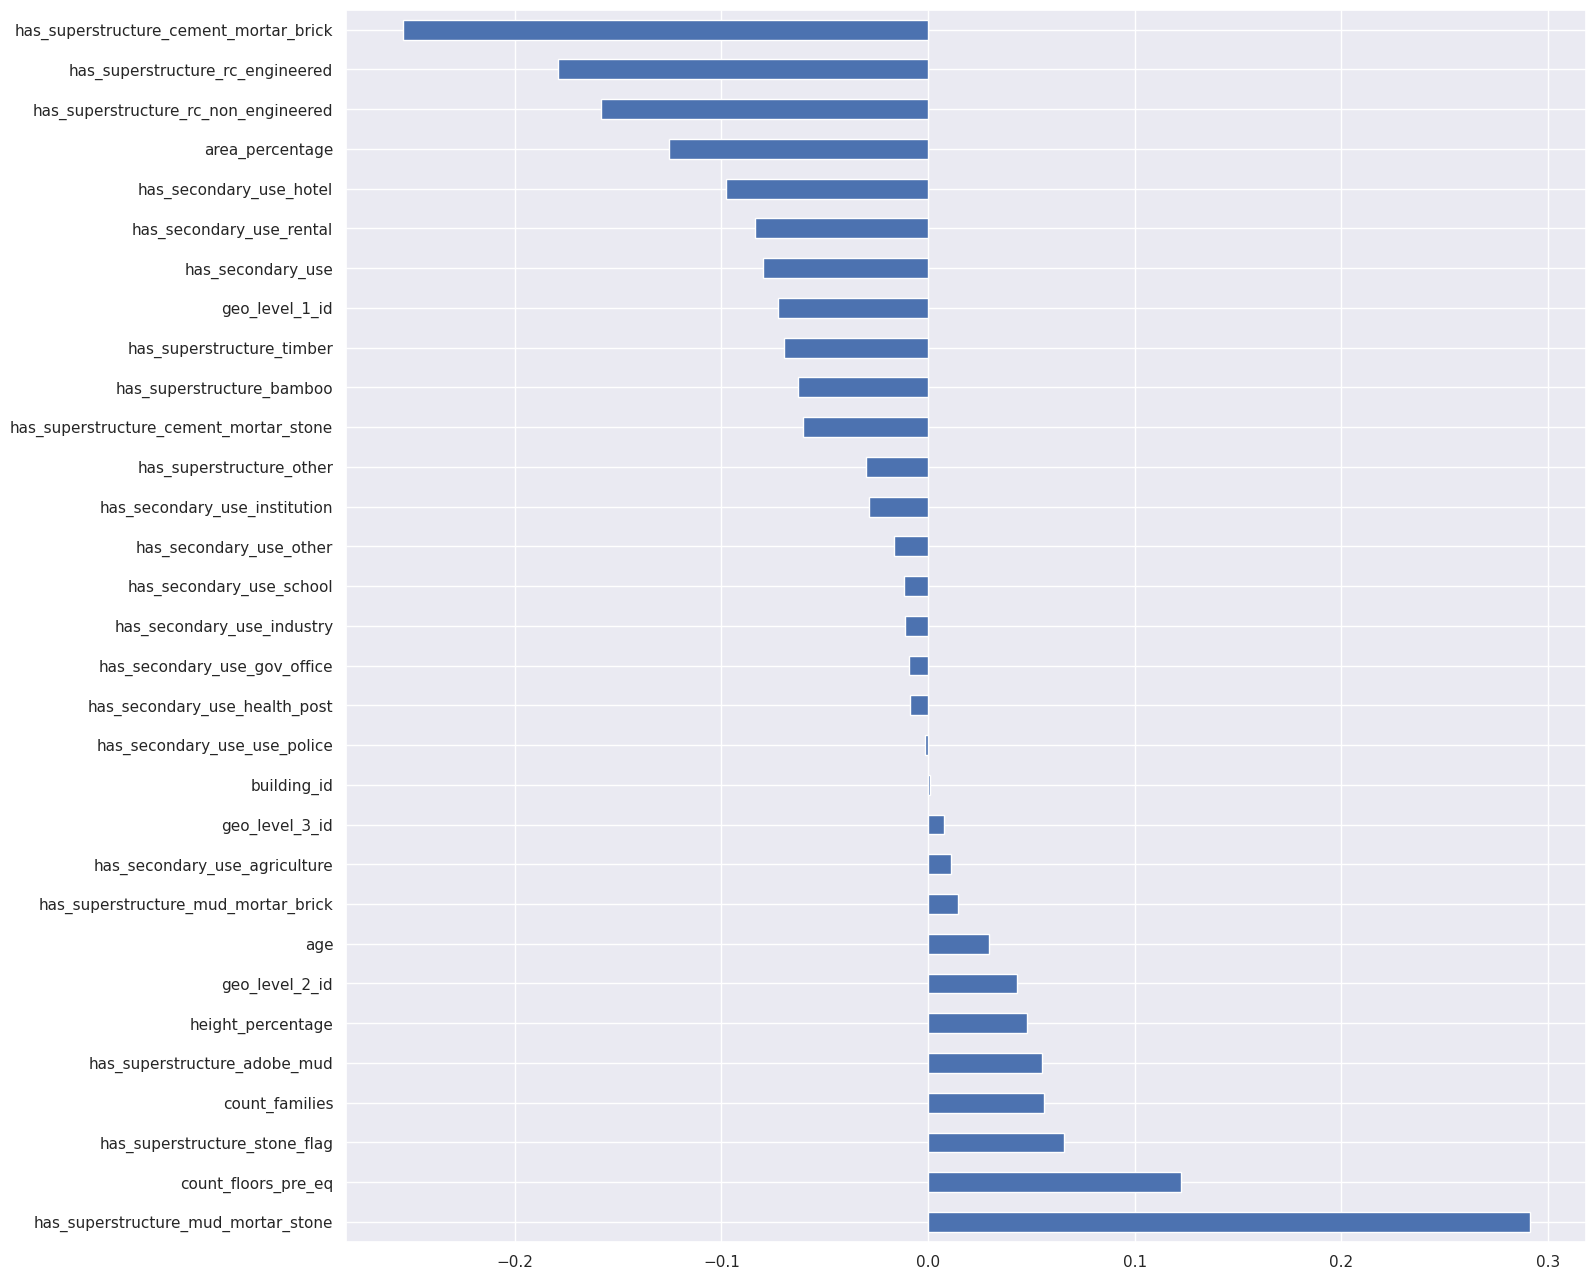

In [32]:
plt.figure(figsize=(16,16))

corr_matrix['damage_grade'].drop('damage_grade').sort_values(ascending=False).plot(kind='barh')
plt.show()

### EDA (Recommendation Material and Characteristic)

In [33]:
list_corr = corr_matrix['damage_grade'].drop('damage_grade')

#### Recommendation Material

Define *features* that are included in the material category
* ***has_superstructure_adobe_mud***
* ***has_superstructure_mud_mortar_stone***
* ***has_superstructure_stone_flag***
* ***has_superstructure_cement_mortar_stone***
* ***has_superstructure_mud_mortar_brick***
* ***has_superstructure_cement_mortar_brick***
* ***has_superstructure_timber***
* ***has_superstructure_bamboo***
* ***has_superstructure_rc_non_engineered***
* ***has_superstructure_rc_engineered***
* ***has_superstructure_other***


In [34]:
list_corr.loc[[
              'has_superstructure_adobe_mud',
              'has_superstructure_mud_mortar_stone',
              'has_superstructure_stone_flag',
              'has_superstructure_cement_mortar_stone',
              'has_superstructure_mud_mortar_brick',
              'has_superstructure_cement_mortar_brick',
              'has_superstructure_timber',
              'has_superstructure_bamboo',
              'has_superstructure_rc_non_engineered',
              'has_superstructure_rc_engineered',
              'has_superstructure_other'
              ]]

has_superstructure_adobe_mud              0.055314
has_superstructure_mud_mortar_stone       0.291325
has_superstructure_stone_flag             0.066039
has_superstructure_cement_mortar_stone   -0.060295
has_superstructure_mud_mortar_brick       0.014561
has_superstructure_cement_mortar_brick   -0.254131
has_superstructure_timber                -0.069852
has_superstructure_bamboo                -0.063051
has_superstructure_rc_non_engineered     -0.158145
has_superstructure_rc_engineered         -0.179014
has_superstructure_other                 -0.030224
Name: damage_grade, dtype: float64

Based on the picture of the influence of building material *features* on the level of building damage, we will select 4 material *features* that have the highest correlation level with **damage_grade**. The 4 *features* are **has_superstructure_mud_mortar_stone**, **has_superstructure_cement_mortar_brick**, **has_superstructure_rc_engineered**, and **has_superstructure_rc_non_engineered**. Several *insights* were obtained based on data from the previous EDA process, namely.
* Buildings that do not have a superstructure *Reinforce Concrete Engineered* often experience medium and high levels of damage if seen based on the distribution of the number of floors, building height and building area.
* The number of buildings using *Reinforce Concrete Non Engineered* superstructures experienced moderate levels of damage more than the number of buildings using *Reinforce Concrete Engineered* superstructures if seen based on the distribution of the number of floors, building height and building area.
* Buildings that use *Cement Mortar Brick* superstructures experience lower levels of damage than those that do not use them.

Therefore, we can provide recommendations for the characteristics of buildings (houses) with the following characteristics.
* Using *Reinforce Conrete Engineered* superstructure
* Using superstructure *Cement Mortar Brick*

#### Recommendation Characteristic

Define *features* which are included in the characteristic category

* ***count_floors_pre_eq***
* ***age***
* ***area_percentage***
* ***height_percentage***
* ***foundation_type***
* ***roof_type***
* ***ground_floor_type***
* ***other_floor_type***
* ***position***

In [35]:
list_corr.loc[['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']]

count_floors_pre_eq    0.122308
age                    0.029273
area_percentage       -0.125221
height_percentage      0.048130
Name: damage_grade, dtype: float64

Based on the picture of the influence of *features* building characteristics on the level of building damage, it was found that the buildings that experienced the highest level of damage were buildings with the following criteria.
* Building with 2 floors
* Buildings aged 0-50 years
* Buildings with normalized height 3-9 $m$
* Buildings with a normalized area of 4-10 $m^2$

Therefore, we can provide recommendations for the characteristics of buildings (houses) with the following characteristics.
* Buildings with 1 or 3 floors
* Buildings with a normalized height of less than 3 $m$ or more than 9 $m$
* Buildings with a normalized area of less than 4 $m^2$ or more than 10 $m^2$

## Feature Selection

In [36]:
df = features.copy()
df = df.set_index('building_id')
df_num = df.select_dtypes(include=['int64', 'float64'])
df_cat = df.select_dtypes(include=['object'])

### Feature Selection for Numeric Feature

In the previous correlation matrix, it can be seen that there are two *features* that have a high level of correlation (>0.7). A correlation matrix can be used to check multicollinearity. Multicollinearity can cause problems such as redundancy where the two *features* can store similar/similar information. To overcome multicollinearity, we can remove two *features* or one so that there are no *features* that have a high level of correlation with other *features*. We will check between *feature* ***height_percentage*** and ***has_secondary_use_agriculture*** which have a higher correlation level with the target ***damage_grade***.

In [37]:
corr_matrix.loc['height_percentage', 'damage_grade']

0.04813002366999064

In [136]:
print('Correlation of feature height_percentage with damage_grade : {:.4f}'.format(corr_matrix.loc['height_percentage', 'damage_grade']))
print('Correlation of feature has_secondary_use_agriculture with damage_grade : {:.4f}'.format(corr_matrix.loc['has_secondary_use_agriculture', 'damage_grade']))

Correlation of feature height_percentage with damage_grade : 0.0481
Correlation of feature has_secondary_use_agriculture with damage_grade : 0.0113


Based on the correlation value above, it can be seen that *feature* ***height_percentage*** has a higher correlation level, so we will discard *feature* ***has_secondary_use_agriculture***.

In [39]:
df_num = df_num.drop('has_secondary_use_agriculture', axis=1)
df_num.shape

(260601, 30)

### Feature Selection for Categorical Feature

The categorical type *feature* selection process will use *SelectKBest*. Using this, the *chi squared* metric is used, where the higher the *chi squared*, the more significant the influence of the *feature*.

In [40]:
df_cat = pd.get_dummies(df_cat)
df_cat.head()

land_surface_condition_n  land_surface_condition_o  \
building_id                                                       
802906                              0                         0   
28830                               0                         1   
94947                               0                         0   
590882                              0                         0   
201944                              0                         0   

             land_surface_condition_t  foundation_type_h  foundation_type_i  \
building_id                                                                   
802906                              1                  0                  0   
28830                               0                  0                  0   
94947                               1                  0                  0   
590882                              1                  0                  0   
201944                              1                  0                  0   

             foundation_type_r  foundation_type_u  foundation_type_w  \
building_id                                                            
802906                       1                  0                  0   
28830                        1                  0                  0   
94947                        1                  0                  0   
590882                       1                  0                  0   
201944                       1                  0                  0   

             roof_type_n  roof_type_q  ...  plan_configuration_m  \
building_id                            ...                         
802906                 1            0  ...                     0   
28830                  1            0  ...                     0   
94947                  1            0  ...                     0   
590882                 1            0  ...                     0   
201944                 1            0  ...                     0   

             plan_configuration_n  plan_configuration_o  plan_configuration_q  \
building_id                                                                     
802906                          0                     0                     0   
28830                           0                     0                     0   
94947                           0                     0                     0   
590882                          0                     0                     0   
201944                          0                     0                     0   

             plan_configuration_s  plan_configuration_u  \
building_id                                               
802906                          0                     0   
28830                           0                     0   
94947                           0                     0   
590882                          0                     0   
201944                          0                     0   

             legal_ownership_status_a  legal_ownership_status_r  \
building_id                                                       
802906                              0                         0   
28830                               0                         0   
94947                               0                         0   
590882                              0                         0   
201944                              0                         0   

             legal_ownership_status_v  legal_ownership_status_w  
building_id                                                      
802906                              1                         0  
28830                               1                         0  
94947                               1                         0  
590882                              1                         0  
201944                              1                         0  

[5 rows x 38 columns]

In [41]:
df_cat.shape

(260601, 38)

In [42]:
category_rank_feature = SelectKBest(score_func=chi2, k=38)
rank_feature = category_rank_feature.fit(df_cat, df_num['damage_grade'])
rank_feature.scores_

array([3.14202700e+02, 6.77046429e+01, 6.77640172e+01, 4.15860728e+02,
       2.79293047e+04, 6.39195232e+03, 5.49424844e+03, 8.31579458e+03,
       1.04584801e+03, 1.15697625e+03, 2.80485950e+04, 3.68489235e+03,
       9.75543604e+01, 3.24654211e+04, 6.05516649e+01, 1.22429528e+02,
       7.42291993e+03, 5.10846128e+03, 1.85494082e+04, 4.06602490e+02,
       2.59354872e+02, 1.48779877e+02, 4.93714399e+01, 6.22421247e+02,
       1.09200110e+02, 1.50572497e+02, 3.04753264e+01, 3.34305427e+00,
       1.36435198e+01, 1.65187836e+00, 5.72019260e+01, 3.23110604e+02,
       3.31565900e+01, 1.01176162e+03, 2.26362245e+03, 5.34417037e+01,
       3.96056239e+01, 2.29493063e+02])

In [43]:
cat_score = pd.DataFrame(rank_feature.scores_, columns=['Score'])
cat_col = pd.DataFrame(df_cat.columns, columns=['Feature'])
univariate_cat_rank = pd.concat([cat_col, cat_score], axis=1)
univariate_cat_rank.set_index('Feature', inplace=True)
sorted_univariate_cat_rank = univariate_cat_rank.sort_values('Score', ascending=False)

Take *feature* with a chi2 value of more than 100.

In [44]:
chi2_greater100 = sorted_univariate_cat_rank[sorted_univariate_cat_rank['Score']>100]

### Merge Numeric and Categorical Feature

In [45]:
df_new = pd.concat([df_num, df_cat], axis=1)

In [46]:
df_new.head()

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
802906                    6             487           12198   
28830                     8             900            2812   
94947                    21             363            8973   
590882                   22             418           10694   
201944                   11             131            1488   

             count_floors_pre_eq  age  area_percentage  height_percentage  \
building_id                                                                 
802906                         2   30                6                  5   
28830                          2   10                8                  7   
94947                          2   10                5                  5   
590882                         2   10                6                  5   
201944                         3   30                8                  9   

             has_superstructure_adobe_mud  \
building_id                                 
802906                                  1   
28830                                   0   
94947                                   0   
590882                                  0   
201944                                  1   

             has_superstructure_mud_mortar_stone  \
building_id                                        
802906                                         1   
28830                                          1   
94947                                          1   
590882                                         1   
201944                                         0   

             has_superstructure_stone_flag  ...  plan_configuration_m  \
building_id                                 ...                         
802906                                   0  ...                     0   
28830                                    0  ...                     0   
94947                                    0  ...                     0   
590882                                   0  ...                     0   
201944                                   0  ...                     0   

             plan_configuration_n  plan_configuration_o  plan_configuration_q  \
building_id                                                                     
802906                          0                     0                     0   
28830                           0                     0                     0   
94947                           0                     0                     0   
590882                          0                     0                     0   
201944                          0                     0                     0   

             plan_configuration_s  plan_configuration_u  \
building_id                                               
802906                          0                     0   
28830                           0                     0   
94947                           0                     0   
590882                          0                     0   
201944                          0                     0   

             legal_ownership_status_a  legal_ownership_status_r  \
building_id                                                       
802906                              0                         0   
28830                               0                         0   
94947                               0                         0   
590882                              0                         0   
201944                              0                         0   

             legal_ownership_status_v  legal_ownership_status_w  
building_id                                                      
802906                              1                         0  
28830                               1                         0  
94947                               1                         0  
590882                              1                   

## Building Model

### Split Data into Train Data and Validation Data

Separate the data that will be used as labels or target variables from other *features*. In this case we create a variable y that stores the target variable and X that stores other *features*.

In [47]:
data = df_new.copy()
y = data['damage_grade']
X = data[list(df_num.columns)+list(chi2_greater100.index)]
X.drop('damage_grade', axis=1, inplace=True)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208480, 54), (52121, 54), (208480,), (52121,))

In [49]:
X_train.head()

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
882292                   20             281            7097   
193569                   26             886           12157   
898082                   26              36            1125   
136982                   13            1372            4555   
742018                    8             206            6064   

             count_floors_pre_eq  age  area_percentage  height_percentage  \
building_id                                                                 
882292                         2   15                6                  7   
193569                         2   10                6                  6   
898082                         1    0                5                  3   
136982                         2   10                6                  5   
742018                         3   35                6                  5   

             has_superstructure_adobe_mud  \
building_id                                 
882292                                  0   
193569                                  0   
898082                                  0   
136982                                  0   
742018                                  0   

             has_superstructure_mud_mortar_stone  \
building_id                                        
882292                                         1   
193569                                         0   
898082                                         0   
136982                                         1   
742018                                         1   

             has_superstructure_stone_flag  ...  foundation_type_h  \
building_id                                 ...                      
882292                                   0  ...                  0   
193569                                   0  ...                  0   
898082                                   0  ...                  0   
136982                                   0  ...                  0   
742018                                   0  ...                  0   

             other_floor_type_x  plan_configuration_q  \
building_id                                             
882292                        0                     0   
193569                        0                     0   
898082                        0                     0   
136982                        0                     0   
742018                        1                     0   

             land_surface_condition_n  position_j  legal_ownership_status_w  \
building_id                                                                   
882292                              0           0                         0   
193569                              0           0                         0   
898082                              1           0                         0   
136982                              0           0                         0   
742018                              0           0                         0   

             plan_configuration_c  position_o  ground_floor_type_z  \
building_id                                                          
882292                          0           0                    0   
193569                          0           0                    0   
898082                          0           0                    0   
136982                          0           0                    0   
742018                          0           0                    0   

             plan_configuration_a  
building_id                        
882292                          0  
193569                          0  
898082                          0  
136982                          0  
742018                          0  

[5 rows x 54 columns]

In [50]:
X_test.head()

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
315409                    6             449             484   
838451                   27             548            2513   
808750                   24             780            9035   
322968                   10             661            6346   
212418                   10            1207             276   

             count_floors_pre_eq  age  area_percentage  height_percentage  \
building_id                                                                 
315409                         2    0                9                  8   
838451                         2    0                5                  5   
808750                         3   25                4                  7   
322968                         3   30                6                  7   
212418                         2   15                5                  5   

             has_superstructure_adobe_mud  \
building_id                                 
315409                                  0   
838451                                  0   
808750                                  0   
322968                                  0   
212418                                  0   

             has_superstructure_mud_mortar_stone  \
building_id                                        
315409                                         1   
838451                                         1   
808750                                         1   
322968                                         1   
212418                                         1   

             has_superstructure_stone_flag  ...  foundation_type_h  \
building_id                                 ...                      
315409                                   0  ...                  0   
838451                                   0  ...                  0   
808750                                   0  ...                  0   
322968                                   0  ...                  0   
212418                                   0  ...                  0   

             other_floor_type_x  plan_configuration_q  \
building_id                                             
315409                        0                     0   
838451                        0                     0   
808750                        0                     0   
322968                        0                     0   
212418                        0                     0   

             land_surface_condition_n  position_j  legal_ownership_status_w  \
building_id                                                                   
315409                              0           0                         0   
838451                              0           0                         0   
808750                              0           0                         0   
322968                              0           0                         0   
212418                              0           0                         0   

             plan_configuration_c  position_o  ground_floor_type_z  \
building_id                                                          
315409                          0           0                    0   
838451                          0           0                    0   
808750                          0           0                    0   
322968                          0           0                    0   
212418                          0           0                    0   

             plan_configuration_a  
building_id                        
315409                          0  
838451                          0  
808750                          0  
322968                          0  
212418                          0  

[5 rows x 54 columns]

In [51]:
y_train.head().to_frame()

damage_grade
building_id              
882292                  1
193569                  1
898082                  1
136982                  2
742018                  3

In [52]:
y_test.head().to_frame()

damage_grade
building_id              
315409                  2
838451                  3
808750                  2
322968                  2
212418                  3

### Scaling Data

In the *preprocessing* data stage, we will apply **StandardScaler** to normalize the data in *scaled_col*

In [53]:
scaler = StandardScaler()

scaled_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
              'count_floors_pre_eq', 'age', 'area_percentage',
              'height_percentage']

X_train[scaled_col] = scaler.fit_transform(X_train[scaled_col])
X_test[scaled_col] = scaler.transform(X_test[scaled_col])

In [54]:
X_train.head()

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
882292             0.758641       -1.019753        0.228478   
193569             1.505643        0.446238        1.615688   
898082             1.505643       -1.613419       -1.408759   
136982            -0.112861        1.623877       -0.468417   
742018            -0.735362       -1.201487       -0.054721   

             count_floors_pre_eq       age  area_percentage  \
building_id                                                   
882292                 -0.178354 -0.156363        -0.461464   
193569                 -0.178354 -0.224906        -0.461464   
898082                 -1.556477 -0.361991        -0.690498   
136982                 -0.178354 -0.224906        -0.461464   
742018                  1.199770  0.117809        -0.461464   

             height_percentage  has_superstructure_adobe_mud  \
building_id                                                    
882292                0.817733                             0   
193569                0.295711                             0   
898082               -1.270355                             0   
136982               -0.226311                             0   
742018               -0.226311                             0   

             has_superstructure_mud_mortar_stone  \
building_id                                        
882292                                         1   
193569                                         0   
898082                                         0   
136982                                         1   
742018                                         1   

             has_superstructure_stone_flag  ...  foundation_type_h  \
building_id                                 ...                      
882292                                   0  ...                  0   
193569                                   0  ...                  0   
898082                                   0  ...                  0   
136982                                   0  ...                  0   
742018                                   0  ...                  0   

             other_floor_type_x  plan_configuration_q  \
building_id                                             
882292                        0                     0   
193569                        0                     0   
898082                        0                     0   
136982                        0                     0   
742018                        1                     0   

             land_surface_condition_n  position_j  legal_ownership_status_w  \
building_id                                                                   
882292                              0           0                         0   
193569                              0           0                         0   
898082                              1           0                         0   
136982                              0           0                         0   
742018                              0           0                         0   

             plan_configuration_c  position_o  ground_floor_type_z  \
building_id                                                          
882292                          0           0                    0   
193569                          0           0                    0   
898082                          0           0                    0   
136982                          0           0                    0   
742018                          0           0                    0   

             plan_configuration_a  
building_id                        
882292                          0  
193569                          0  
898082                          0  
136982                          0  
742018                          0  

[5 rows x 54 columns]

In [55]:
X_test.head()

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
315409            -0.984363       -0.612668       -1.584491   
838451             1.630143       -0.372778       -1.028236   
808750             1.256643        0.189387        0.759785   
322968            -0.486362       -0.098965        0.022590   
212418            -0.486362        1.224061       -1.641514   

             count_floors_pre_eq       age  area_percentage  \
building_id                                                   
315409                 -0.178354 -0.361991         0.225640   
838451                 -0.178354 -0.361991        -0.690498   
808750                  1.199770 -0.019277        -0.919532   
322968                  1.199770  0.049266        -0.461464   
212418                 -0.178354 -0.156363        -0.690498   

             height_percentage  has_superstructure_adobe_mud  \
building_id                                                    
315409                1.339754                             0   
838451               -0.226311                             0   
808750                0.817733                             0   
322968                0.817733                             0   
212418               -0.226311                             0   

             has_superstructure_mud_mortar_stone  \
building_id                                        
315409                                         1   
838451                                         1   
808750                                         1   
322968                                         1   
212418                                         1   

             has_superstructure_stone_flag  ...  foundation_type_h  \
building_id                                 ...                      
315409                                   0  ...                  0   
838451                                   0  ...                  0   
808750                                   0  ...                  0   
322968                                   0  ...                  0   
212418                                   0  ...                  0   

             other_floor_type_x  plan_configuration_q  \
building_id                                             
315409                        0                     0   
838451                        0                     0   
808750                        0                     0   
322968                        0                     0   
212418                        0                     0   

             land_surface_condition_n  position_j  legal_ownership_status_w  \
building_id                                                                   
315409                              0           0                         0   
838451                              0           0                         0   
808750                              0           0                         0   
322968                              0           0                         0   
212418                              0           0                         0   

             plan_configuration_c  position_o  ground_floor_type_z  \
building_id                                                          
315409                          0           0                    0   
838451                          0           0                    0   
808750                          0           0                    0   
322968                          0           0                    0   
212418                          0           0                    0   

             plan_configuration_a  
building_id                        
315409                          0  
838451                          0  
808750                          0  
322968                          0  
212418                          0  

[5 rows x 54 columns]

### Using Cross Validation

In comparing the *performance* of several *machine learning* algorithms that will be tested, we will use the **F1 Score Micro** metric. The reason for using **F1 Score** as a metric is that we want to create a machine learning model that can maximize the value of good *Precision* and *Recall*. Metrics *Precision* and *Recall* are considered important because the FN(*False Negative*) and FP(*False Positive*) values are important factors. Additionally, the **F1 Score** metric is considered better when working with imbalanced classes. **Micro** itself was chosen because we want to first calculate the sum of all TP(*True Positive*), FP(*False Positive*), and FN(*False Negative*) from all classes in the target variable.

Define a function to create a *confusion matrix*

In [56]:
def make_confusion_matrix(pred, title):
    cam = confusion_matrix(y_test, pred)
    sns.heatmap(cam, annot=True, cmap='viridis',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'],
                fmt="d")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Using {} Algorithm'.format(title))
    plt.show()

#### Logistic Regression

In [57]:
model_cv_1 = LogisticRegression(random_state=0)
kfold = KFold(n_splits=10)
scores_1 = cross_val_score(model_cv_1, X_train, y_train, scoring="f1_micro", cv=kfold)
result_1 = scores_1.mean()
print('Average F1 Score (Micro) for Logistic Algorithm is : {}'.format(result_1))

Average F1 Score (Micro) for Logistic Algorithm is : 0.5910830775134305


#### Decision Tree

In [58]:
model_cv_2 = DecisionTreeClassifier(random_state=0)
kfold = KFold(n_splits=10)
scores_2 = cross_val_score(model_cv_2, X_train, y_train, scoring="f1_micro", cv=kfold)
result_2 = scores_2.mean()
print('Average F1 Score (Micro) for Decision Tree is : {}'.format(result_2))

Average F1 Score (Micro) for Decision Tree is : 0.6576026477359939


#### K-Nearest Neighbors

In [59]:
model_cv_3 = KNeighborsClassifier()
kfold = KFold(n_splits=10)
scores_3 = cross_val_score(model_cv_3, X_train, y_train, scoring="f1_micro", cv=kfold)
result_3 = scores_3.mean()
print('Average F1 Score (Micro) for K-Nearest Neighbors is : {}'.format(result_3))

Average F1 Score (Micro) for K-Nearest Neighbors is : 0.6560197620874904


#### Naive Bayes

In [98]:
model_cv_4 = GaussianNB()
kfold = KFold(n_splits=10)
scores_4 = cross_val_score(model_cv_4, X_train, y_train, scoring="f1_micro", cv=kfold)
result_4 = scores_4.mean()
print('Average F1 Score (Micro) for Naive Bayes is : {}'.format(result_4))

Average F1 Score (Micro) for Naive Bayes is : 0.430962202609363


#### Extreme Gradient Boosting

In [99]:
model_cv_5 = XGBClassifier(verbosity=0)
kfold = KFold(n_splits=10)
scores_5 = cross_val_score(model_cv_5, X_train, y_train - 1, scoring="f1_micro", cv=kfold)
result_5 = scores_5.mean()
print('Average F1 Score (Micro) for Extreme Gradient Boosting is : {}'.format(result_5))


Average F1 Score (Micro) for Extreme Gradient Boosting is : 0.7245539140445126


#### Random Forest

In [83]:
model_cv_6 = RandomForestClassifier(random_state=0)
kfold = KFold(n_splits=10)
scores_6 = cross_val_score(model_cv_6, X_train, y_train, scoring="f1_micro", cv=kfold)
result_6 = scores_6.mean()
print('Average F1 Score (Micro) for Random Forest is : {}'.format(result_6))

Average F1 Score (Micro) for Random Forest is : 0.7145577513430544


### Fit and Predict Several Algorithm

#### Logistic Regression

              precision    recall  f1-score   support

           1       0.57      0.30      0.39      4979
           2       0.60      0.88      0.71     29703
           3       0.56      0.20      0.29     17439

    accuracy                           0.59     52121
   macro avg       0.58      0.46      0.47     52121
weighted avg       0.58      0.59      0.54     52121



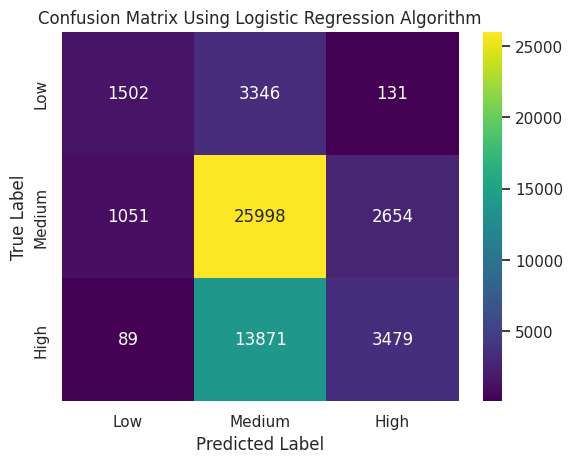

Train F1 Score (Micro) for Logistic Regression Algorithm is : 0.591514773599386
Test F1 Score (Micro) for Logistic Regression Algorithm is : 0.5943669538189981


In [88]:
import os

model_filename = 'model_1.pkl'

# Save the model
with open(model_filename, 'wb') as file:
    pickle.dump(model_1, file)

# Check if the file exists before loading
if os.path.exists(model_filename):
    # Load the model
    with open(model_filename, 'rb') as file:
        model_1 = pickle.load(file)

    # Make predictions
    pred_1 = model_1.predict(X_test)
    train_pred_1 = model_1.predict(X_train)

    # Evaluate the model
    print(classification_report(y_test, pred_1))
    make_confusion_matrix(pred_1, 'Logistic Regression')
    train_score_1 = f1_score(y_train, train_pred_1, average='micro')
    score_1 = f1_score(y_test, pred_1, average='micro')
    print('Train F1 Score (Micro) for Logistic Regression Algorithm is : {}'.format(train_score_1))
    print('Test F1 Score (Micro) for Logistic Regression Algorithm is : {}'.format(score_1))
else:
    print(f"Model file '{model_filename}' not found.")


#### Decision Tree

In [90]:
import os

model_filename = 'model_2.pkl'

# Save the model
with open(model_filename, 'wb') as file:
    pickle.dump(model_2, file)

# Check if the file exists before loading
if os.path.exists(model_filename):
    # Load the model
    with open(model_filename, 'rb') as file:
        model_2 = pickle.load(file)

    # Make predictions
    pred_2 = model_2.predict(X_test)
    train_pred_2 = model_2.predict(X_train)

    # Evaluate the model
    print(classification_report(y_test, pred_2))
    train_score_2 = f1_score(y_train, train_pred_2, average='micro')
    score_2 = f1_score(y_test, pred_2, average='micro')
    print('Train F1 Score (Micro) for Decision Tree Algorithm is : {}'.format(train_score_2))
    print('Test F1 Score (Micro) for Decision Tree Algorithm is : {}'.format(score_2))



              precision    recall  f1-score   support

           1       0.48      0.51      0.50      4979
           2       0.71      0.71      0.71     29703
           3       0.62      0.61      0.62     17439

    accuracy                           0.66     52121
   macro avg       0.61      0.61      0.61     52121
weighted avg       0.66      0.66      0.66     52121

Train F1 Score (Micro) for Decision Tree Algorithm is : 0.9864207597851112
Test F1 Score (Micro) for Decision Tree Algorithm is : 0.6599643138082538


#### K-Nearest Neighbors

In [97]:
from sklearn.neighbors import KNeighborsClassifier
import pickle

# Assuming X_train and y_train are the training data
model_3 = KNeighborsClassifier()
model_3.fit(X_train, y_train)

# Save the model to a file
with open('model_3.pkl', 'wb') as file:
    pickle.dump(model_3, file)

# Later, when you want to load the model
with open('model_3.pkl', 'rb') as file:
    model_3 = pickle.load(file)

# Now you can use the loaded model
pred_3 = model_3.predict(X_test)
train_pred_3 = model_3.predict(X_train)

print(classification_report(y_test, pred_3))
train_score_3 = f1_score(y_train, train_pred_3, average='micro')
score_3 = f1_score(y_test, pred_3, average='micro')
print('Train F1 Score (Micro) for K-Nearest Neighbors Algorithm is : {}'.format(train_score_3))
print('Test F1 Score (Micro) for K-Nearest Neighbors Algorithm is : {}'.format(score_3))




              precision    recall  f1-score   support

           1       0.52      0.46      0.49      4979
           2       0.69      0.75      0.72     29703
           3       0.63      0.56      0.59     17439

    accuracy                           0.66     52121
   macro avg       0.61      0.59      0.60     52121
weighted avg       0.65      0.66      0.66     52121

Train F1 Score (Micro) for K-Nearest Neighbors Algorithm is : 0.7661214504988488
Test F1 Score (Micro) for K-Nearest Neighbors Algorithm is : 0.6589666353293299


#### Naive Bayes

In [106]:
from sklearn.naive_bayes import GaussianNB
import pickle

# Assuming X_train and y_train are the training data
model_4 = GaussianNB()
model_4.fit(X_train, y_train)

# Save the model to a file
with open('model_4.pkl', 'wb') as file:
    pickle.dump(model_4, file)

# Later, when you want to load the model
with open('model_4.pkl', 'rb') as file:
    model_4 = pickle.load(file)

# Now you can use the loaded model
pred_4 = model_4.predict(X_test)
train_pred_4 = model_4.predict(X_train)

print(classification_report(y_test, pred_4))
train_score_4 = f1_score(y_train, train_pred_4, average='micro')
score_4 = f1_score(y_test, pred_4, average='micro')
print('Train F1 Score (Micro) for Naive Bayes Algorithm is : {}'.format(train_score_4))
print('Test F1 Score (Micro) for Naive Bayes Algorithm is : {}'.format(score_4))


              precision    recall  f1-score   support

           1       0.39      0.52      0.45      4979
           2       0.66      0.15      0.25     29703
           3       0.40      0.88      0.55     17439

    accuracy                           0.43     52121
   macro avg       0.49      0.52      0.42     52121
weighted avg       0.55      0.43      0.37     52121

Train F1 Score (Micro) for Naive Bayes Algorithm is : 0.43118284727551803
Test F1 Score (Micro) for Naive Bayes Algorithm is : 0.4337982770860114


#### Extreme Gradient Boosting

In [103]:
from sklearn.naive_bayes import GaussianNB
import pickle

# Assuming X_train and y_train are the training data
model_5 = XGBClassifier(verbosity=0)
model_5.fit(X_train, y_train-1)

# Save the model to a file
with open('model_5.pkl', 'wb') as file:
    pickle.dump(model_5, file)

# Later, when you want to load the model
with open('model_5.pkl', 'rb') as file:
    model_5 = pickle.load(file)

# Now you can use the loaded model
pred_5 = model_5.predict(X_test)
train_pred_5 = model_5.predict(X_train)

print(classification_report(y_test, pred_5))
train_score_5 = f1_score(y_train, train_pred_5, average='micro')
score_5 = f1_score(y_test, pred_5, average='micro')
print('Train F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : {}'.format(train_score_5))
print('Test F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : {}'.format(score_5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.08      0.54      0.13      4979
           2       0.25      0.11      0.16     29703
           3       0.00      0.00      0.00     17439

    accuracy                           0.12     52121
   macro avg       0.08      0.16      0.07     52121
weighted avg       0.15      0.12      0.10     52121

Train F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : 0.10918553338449731
Test F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : 0.11651733466357131


#### Random Forest

In [104]:
from sklearn.ensemble import RandomForestClassifier
import pickle

# Assuming X_train and y_train are the training data
model_6 = RandomForestClassifier(random_state=0)
model_6.fit(X_train, y_train)

# Save the model to a file
with open('model_6.pkl', 'wb') as file:
    pickle.dump(model_6, file)

# Later, when you want to load the model
with open('model_6.pkl', 'rb') as file:
    model_6 = pickle.load(file)

# Now you can use the loaded model
pred_6 = model_6.predict(X_test)
train_pred_6 = model_6.predict(X_train)

print(classification_report(y_test, pred_6))
train_score_6 = f1_score(y_train, train_pred_6, average='micro')
score_6 = f1_score(y_test, pred_6, average='micro')
print('Train F1 Score (Micro) for Random Forest Algorithm is : {}'.format(train_score_6))
print('Test F1 Score (Micro) for Random Forest Algorithm is : {}'.format(score_6))


              precision    recall  f1-score   support

           1       0.64      0.47      0.54      4979
           2       0.72      0.83      0.77     29703
           3       0.72      0.59      0.65     17439

    accuracy                           0.71     52121
   macro avg       0.69      0.63      0.65     52121
weighted avg       0.71      0.71      0.71     52121

Train F1 Score (Micro) for Random Forest Algorithm is : 0.9864111665387567
Test F1 Score (Micro) for Random Forest Algorithm is : 0.7142418602866407


### Comparing Algorithm

In [107]:
names = ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors',
         'Naive Bayes', 'Extreme Gradient Boosting', 'Random Forest']
cv_score_f1 = [result_1, result_2, result_3, result_4, result_5, result_6]
train_score_f1 = [train_score_1, train_score_2, train_score_3, train_score_4, train_score_5, train_score_6]
score_f1 = [score_1, score_2, score_3,score_4, score_5, score_6]

In [108]:
compare = pd.DataFrame()
compare['Algorithm'] = names
compare['CV F1 Score'] = cv_score_f1
compare['F1 Score (Train)'] = train_score_f1
compare['F1 Score (Test)'] = score_f1
compare

Algorithm  CV F1 Score  F1 Score (Train)  F1 Score (Test)
0        Logistic Regression     0.591083          0.591515         0.594367
1              Decision Tree     0.657603          0.986421         0.659964
2        K-Nearest Neighbors     0.656020          0.766121         0.658967
3                Naive Bayes     0.430962          0.431183         0.433798
4  Extreme Gradient Boosting     0.724554          0.109186         0.116517
5              Random Forest     0.724554          0.986411         0.714242

Using 6 *Machine Learning* algorithms with random_state = 0, we see that the *Random Forest Algorithm* and *Extreme Gradient Boosting* are the 2 algorithms that provide the highest F1 Score when tested on *test* data (*Valudation Data*).

### Hyperparameter Tuning

In the previous section, 2 algorithms were obtained that produced the highest F1 Score values, namely Extreme *Gradient Boosting* and *Random Forest*. Therefore, we will carry out a *Hyperparameter Tuning* process on these two algorithms. The *hyperparameter tuning* process can perform GridSearchCV or RandomizedCV. In this problem, we will use RandomizedCV.

#### Extreme Gradient Boosting Parameter Tuning

In [112]:
from sklearn.metrics import f1_score

# Replace y_test with y_test - 1 to convert classes [1, 2, 3] to [0, 1, 2]
y_test_adjusted = y_test - 1

# Compute F1 score with labels=[0, 1, 2]
score_5_adjusted = f1_score(y_test_adjusted, pred_5, labels=[0, 1, 2], average='micro')
print('Test F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : {}'.format(score_5_adjusted))


Test F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : 0.7246407398169644


In [120]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBClassifier
import pickle

xgb_params = {'n_estimators': range(50, 201, 50),
              'max_depth': range(3, 15)}
xgb_model = XGBClassifier(verbosity=0)
kfold = KFold(n_splits=4)
rscv_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params, n_iter=5,
                              scoring='f1_micro', cv=kfold, random_state=0, n_jobs=-1)

rscv_xgb.fit(X, y-1)

# Save the RandomizedSearchCV object to a file
with open('rscv_xgb.pkl', 'wb') as file:
    pickle.dump(rscv_xgb, file)

# Load the RandomizedSearchCV object from the file
with open('rscv_xgb.pkl', 'rb') as file:
    loaded_rscv_xgb = pickle.load(file)

print("Optimal hyperparameter combination for XGBClassifier:", loaded_rscv_xgb.best_params_)
print()
print("Mean cross-validated training accuracy score:", loaded_rscv_xgb.best_score_)


Optimal hyperparameter combination for XGBClassifier: {'n_estimators': 150, 'max_depth': 10}

Mean cross-validated training accuracy score: 0.7409910234743298


#### Random Forest Parameter Tuning

In [139]:
params = {'n_estimators': range(50, 251, 50),
          'max_depth': range(15, 30),
          'max_features': ['sqrt', 'log2', None]}

rf_model = RandomForestClassifier(random_state=0)
kfold = KFold(n_splits=4)
rscv_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=params, n_iter=5,
                             scoring='f1_micro', cv=kfold, random_state=0, n_jobs=-1)

rscv_rf.fit(X,y)


with open('rscv_rf.pkl', 'wb') as file:
    pickle.dump(rscv_rf, file)

with open('rscv_rf.pkl', 'rb') as file:
    rscv_rf = pickle.load(file)


print("Optimal hyperparameter combination for RandomForestClassifier:", rscv_rf.best_params_)
print()
print("Mean cross-validated training accuracy score:", rscv_rf.best_score_)

Optimal hyperparameter combination for RandomForestClassifier: {'n_estimators': 100, 'max_features': None, 'max_depth': 21}

Mean cross-validated training accuracy score: 0.7339342508335291


### Build Model With Parameter Tuning

#### Extreme Gradient Boosting

In [140]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import pickle

tuning_xgb_model = XGBClassifier(n_estimators=150, max_depth=10, verbosity=0)
tuning_xgb_model.fit(X_train, y_train - 1)  # Subtract 1 to make classes 0-indexed

# Save the trained model
with open('tuning_xgb_model.pkl', 'wb') as file:
    pickle.dump(tuning_xgb_model, file)

# Load the trained model
with open('tuning_xgb_model.pkl', 'rb') as file:
    tuning_xgb_model = pickle.load(file)

# Predict on the test set and calculate F1 score
pred_xgb = tuning_xgb_model.predict(X_test)
train_pred_xgb = tuning_xgb_model.predict(X_train)
print('F1 Score (Micro) on Training Data :', f1_score(y_train, train_pred_xgb, average='micro'))
print('F1 Score (Micro) on Testing Data :', f1_score(y_test, pred_xgb, average='micro'))


F1 Score (Micro) on Training Data : 0.059027244819646975
F1 Score (Micro) on Testing Data : 0.11120277815084131


#### Random Forest

In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import pickle

tuning_rf_model = RandomForestClassifier(n_estimators=100, max_features=None, max_depth=21, random_state=0)
tuning_rf_model.fit(X_train, y_train)

# Save the trained model
with open('tuning_rf_model.pkl', 'wb') as file:
    pickle.dump(tuning_rf_model, file)

# Load the trained model
with open('tuning_rf_model.pkl', 'rb') as file:
    tuning_rf_model = pickle.load(file)

# Predict on the test set and calculate F1 score
pred_rf = tuning_rf_model.predict(X_test)
train_pred_rf = tuning_rf_model.predict(X_train)
print('F1 Score (Micro) on Training Data :', f1_score(y_train, train_pred_rf, average='micro'))
print('F1 Score (Micro) on Testing Data :', f1_score(y_test, pred_rf, average='micro'))



F1 Score (Micro) on Training Data : 0.8994675748273215
F1 Score (Micro) on Testing Data : 0.7350204332226934


### Feature Importance

#### Extreme Gradient Boosting

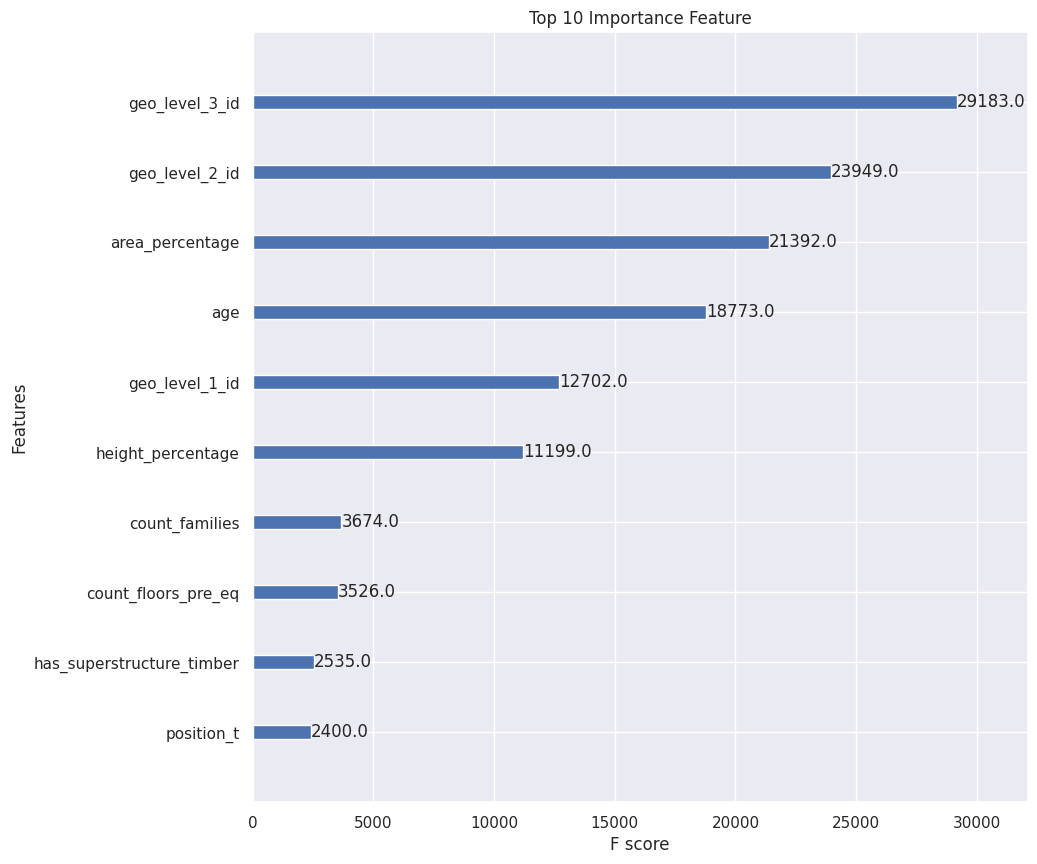

In [142]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(tuning_xgb_model, max_num_features=10, ax=ax)
plt.title('Top 10 Importance Feature')
plt.show()

Using *Extreme Gradient Boosting*, the 10 most important *features* in the model are obtained, namely `geo_level_3_id`, `geo_level_2_id`, `area_percentage`, `age`, `geo_level_1_id`, `height_percentage`, `count_families`, `count_floors_pre_eq`, `has_superstructure_timber `, `position_t`.

#### Random Forest

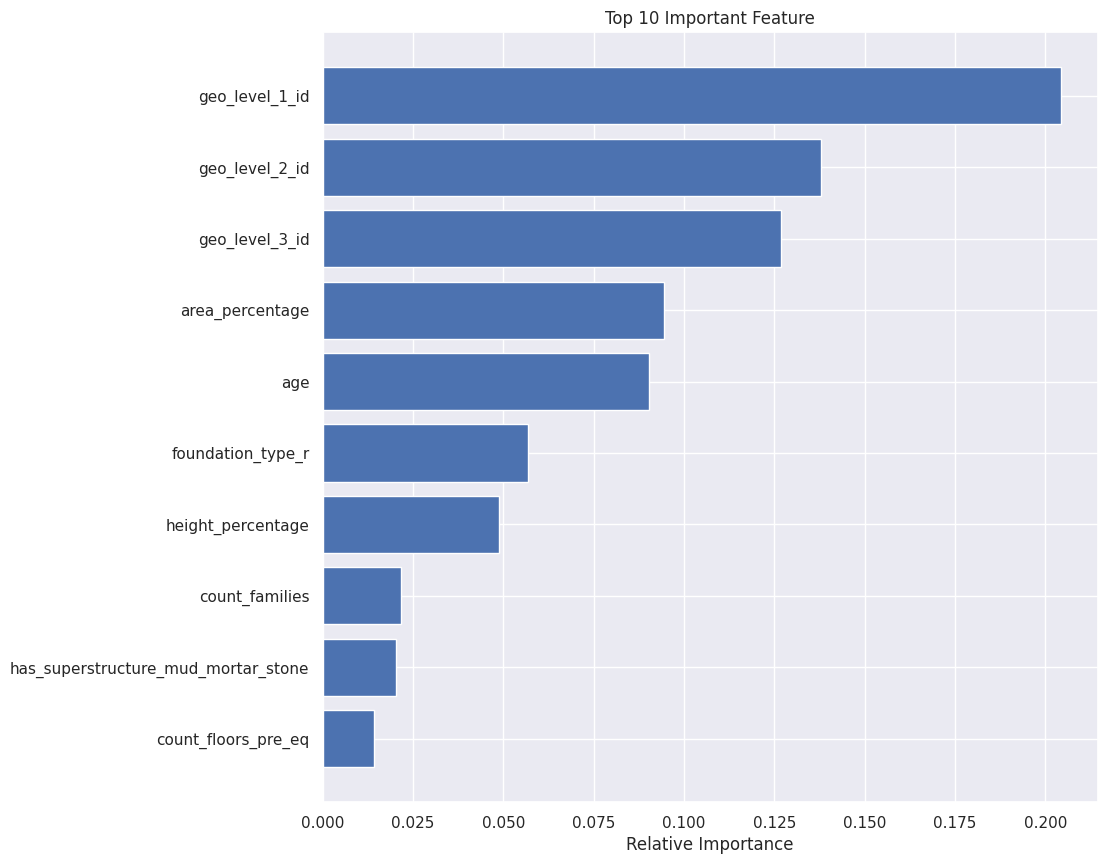

In [143]:
features = X.columns
importances = tuning_rf_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices[-10:])), importances[indices][-10:], color='b', align='center')
plt.yticks(range(len(indices[-10:])), features[indices][-10:])
plt.xlabel('Relative Importance')
plt.title('Top 10 Important Feature')
plt.show()

Using *Random Forest*, the 10 most important *features* in the model are obtained, namely `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id``area_percentage`, `age`, `foundation_type_r`, `height_percentage`, `count_families`, `has_superstructure_mud_mortar_stone`, `count_floors_pre_eq`.

## Final Model

After carrying out the parameter tuning process for *Extreme Gradient Boosting* and *Random Forest*, F1 score values were obtained for both models on *training data* and *validation data*. It can be seen that the model on *Extreme Gradient Boosting* is more stable because the F1 score on *training data* and *validation data* is in the range of 5.90% and 11.12%. Meanwhile in the *Random Forest* model, the F1 score value on *training data* is 89.9% and 73.5% on *validation data*. So in the final model, we will use *Extreme Gradient Boosting* to predict *test data*.

In [144]:
def final_confusion_matrix(pred, title):
    cam = confusion_matrix(y, pred)
    sns.heatmap(cam, annot=True, cmap='viridis',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'],
                fmt="d")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Using {} Algorithm'.format(title))
    plt.show()

In [145]:
scaler_final = StandardScaler()
scaled_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
              'count_floors_pre_eq', 'age', 'area_percentage',
              'height_percentage']
X[scaled_col] = scaler_final.fit_transform(X[scaled_col])

F1 Score (Micro) on Training Data : 0.06380251802564073
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.04      0.23      0.06     25124
           2       0.14      0.07      0.10    148259
           3       0.00      0.00      0.00     87218

    accuracy                           0.06    260601
   macro avg       0.04      0.08      0.04    260601
weighted avg       0.08      0.06      0.06    260601



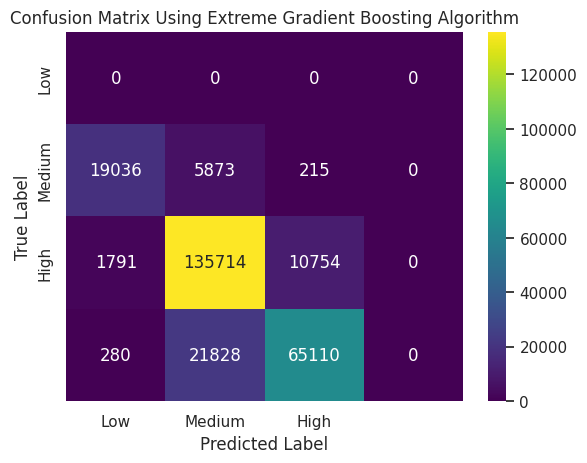

In [148]:
from sklearn.metrics import f1_score, classification_report
import pickle

final_model = XGBClassifier(n_estimators=150, max_depth=10, verbosity=0, tree_method="gpu_hist")
final_model.fit(X, y-1)

# Save the trained model
with open('final_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

# Load the trained model
with open('final_model.pkl', 'rb') as file:
    final_model = pickle.load(file)

# Predict on the training set
pred_final_model = final_model.predict(X)

# Evaluate the model
print('F1 Score (Micro) on Training Data :', f1_score(y, pred_final_model, average='micro'))
print('Classification report: \n', classification_report(y, pred_final_model))
final_confusion_matrix(pred_final_model, 'Extreme Gradient Boosting')


## Predict on Unseen Data

Now, the level of damage to the building will be predicted based on the test data.

In [149]:
test_data = test_value.copy()
test_data = test_data.set_index('building_id')
test_data.head()

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
300051                   17             596           11307   
99355                     6             141           11987   
890251                   22              19           10044   
745817                   26              39             633   
421793                   17             289            7970   

             count_floors_pre_eq  age  area_percentage  height_percentage  \
building_id                                                                 
300051                         3   20                7                  6   
99355                          2   25               13                  5   
890251                         2    5                4                  5   
745817                         1    0               19                  3   
421793                         3   15                8                  7   

            land_surface_condition foundation_type roof_type  ...  \
building_id                                                   ...   
300051                           t               r         n  ...   
99355                            t               r         n  ...   
890251                           t               r         n  ...   
745817                           t               r         x  ...   
421793                           t               r         q  ...   

            has_secondary_use_agriculture has_secondary_use_hotel  \
building_id                                                         
300051                                  0                       0   
99355                                   1                       0   
890251                                  0                       0   
745817                                  0                       0   
421793                                  0                       0   

            has_secondary_use_rental has_secondary_use_institution  \
building_id                                                          
300051                             0                             0   
99355                              0                             0   
890251                             0                             0   
745817                             1                             0   
421793                             0                             0   

             has_secondary_use_school  has_secondary_use_industry  \
building_id                                                         
300051                              0                           0   
99355                               0                           0   
890251                              0                           0   
745817                              0                           0   
421793                              0                           0   

             has_secondary_use_health_post  has_secondary_use_gov_office  \
building_id                                                                
300051                                   0                             0   
99355                                    0                             0   
890251                                   0                             0   
745817                                   0                             0   
421793                                   0                             0   

             has_secondary_use_use_police  has_secondary_use_other  
building_id                                                         
300051                                  0                        0  
99355                                   0                        0  
890251                                  0                        0  
745817                                  0                        0  
421793                                  0                        0  

[5 rows x 38 columns]

In [150]:
test_data_num = test_data.select_dtypes(include=['int64', 'float64'])
test_data_cat = test_data.select_dtypes(include=['object'])

In [151]:
test_data_num = test_data_num.drop('has_secondary_use_agriculture', axis=1)

In [152]:
test_data_cat = pd.get_dummies(test_data_cat)

In [153]:
new_test_data = pd.concat([test_data_num, test_data_cat], axis=1)

In [154]:
scaler = StandardScaler()
scaled_test = new_test_data.copy()
data_train = df_new.copy()
scaled_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
              'count_floors_pre_eq', 'age', 'area_percentage',
              'height_percentage']

scaled_train = data_train[scaled_col]
scaler.fit(scaled_train)
feature_scaled_test = scaled_test[scaled_col]
feature_scaled_test = scaler.transform(feature_scaled_test)
scaled_test[scaled_col] = feature_scaled_test
data_test = scaled_test.copy()

In [155]:
data_test.head()

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
300051             0.385835       -0.254597        1.384702   
99355             -0.983414       -1.357066        1.571189   
890251             1.008221       -1.652673        1.038329   
745817             1.506130       -1.604213       -1.542599   
421793             0.385835       -0.998461        0.469543   

             count_floors_pre_eq       age  area_percentage  \
building_id                                                   
300051                  1.195989 -0.088832        -0.231785   
99355                  -0.178274 -0.020866         1.134266   
890251                 -0.178274 -0.292732        -0.914810   
745817                 -1.552536 -0.360698         2.500317   
421793                  1.195989 -0.156799        -0.004110   

             height_percentage  has_superstructure_adobe_mud  \
building_id                                                    
300051                0.294845                             0   
99355                -0.226419                             0   
890251               -0.226419                             0   
745817               -1.268946                             0   
421793                0.816109                             0   

             has_superstructure_mud_mortar_stone  \
building_id                                        
300051                                         1   
99355                                          1   
890251                                         1   
745817                                         0   
421793                                         1   

             has_superstructure_stone_flag  ...  plan_configuration_m  \
building_id                                 ...                         
300051                                   0  ...                     0   
99355                                    0  ...                     0   
890251                                   0  ...                     0   
745817                                   0  ...                     0   
421793                                   0  ...                     0   

             plan_configuration_n  plan_configuration_o  plan_configuration_q  \
building_id                                                                     
300051                          0                     0                     0   
99355                           0                     0                     0   
890251                          0                     0                     0   
745817                          0                     0                     0   
421793                          0                     0                     0   

             plan_configuration_s  plan_configuration_u  \
building_id                                               
300051                          0                     0   
99355                           0                     0   
890251                          0                     0   
745817                          0                     0   
421793                          0                     0   

             legal_ownership_status_a  legal_ownership_status_r  \
building_id                                                       
300051                              0                         0   
99355                               0                         0   
890251                              0                         0   
745817                              0                         0   
421793                              0                         0   

             legal_ownership_status_v  legal_ownership_status_w  
building_id                                                      
300051                              1                         0  
99355                               1                         0  
890251                              1                         0  
745817               

In [156]:
testing = data_test[list(df_num.drop('damage_grade', axis=1).columns)+list(chi2_greater100.index)]

In [157]:
pred_testing_data = final_model.predict(testing)

In [158]:
final = pd.DataFrame()
final['building_id'] = testing.index
final['damage_grade'] = pred_testing_data

In [159]:
final

building_id  damage_grade
0           300051             2
1            99355             1
2           890251             1
3           745817             0
4           421793             2
...            ...           ...
86863       310028             1
86864       663567             1
86865      1049160             1
86866       442785             1
86867       501372             0

[86868 rows x 2 columns]

The prediction results in the form of building damage levels will be saved in a CSV file.

In [160]:
final.to_csv('Damage Grade Prediction.csv', index=False)

# Conclusion

Based on the process that has been carried out, several conclusions can be obtained that can answer the previous problems. This conclusion is expected to answer the problems previously defined.

1. Get an idea of the damage to buildings in Nepal <br>
Answer: <br>
After carrying out the *Exploratory Data Analysis* process, the average level of damage was obtained at **2.238272** which states that the building experienced a medium level of damage. The details are that **148259** buildings experienced medium levels of damage, **87218** buildings experienced high levels of damage, and **25124** buildings experienced low levels of damage. It can be seen that the number of buildings with a medium level of damage is the largest, namely **56.89%** followed by buildings with a high level of damage at **33.47%** and finally buildings with a low level of damage at **9.64%**. The higher geographic levels between **`geo_level_1_id`**, **`geo_level_2_id`**, and **`geo_level_3_id`** provide information that the higher the geographic level, the more the same level of damage.

2. Provide recommendations in the form of specific materials or characteristics that can be used in constructing a building to reduce the impact of damage caused by an earthquake. <br>
Answer: <br>
Recommendations for buildings that are considered to minimize the impact of earthquakes are obtained as follows.
     * Buildings that use ***Reinforce Concrete Engineered*** or ***Cement Mortar Brick*** superstructures
     * Buildings with **1** or **3** floors
     * Buildings with a normalized height of less than **3** meters or more than **9** meters
     * Buildings with a normalized area of less than **4** square meters or more than **10** square meters.

3. Predict the level of damage to buildings affected by the 2015 Nepal earthquake. <br>
Answer: <br>
We can predict the process of predicting the level of damage caused by the 2015 Nepal earthquake to buildings using the *Machine Learning* algorithm. The model with the highest *F1 Score* value in predicting the level of damage caused by earthquakes to buildings is the ***Random Forest*** algorithm model using *RandomForestClassifier* by entering the parameters `n_estimators=100` and `max_depth=21`. Using this model, an *F1 Score* value of **73.50%** is obtained. Using this model, it can be seen that the 10 most important *features* in the model are `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id``area_percentage`, `age`, `foundation_type_r`, `height_percentage`, `count_families`, `has_superstructure_mud_mortar_stone`, `count_floors_pre_eq`. This is in accordance with the situation because `geo_level` which is the geographical area where the building is located is one of the important factors for predicting the level of damage to buildings due to an earthquake. For areas located at the epicenter of the earthquake, buildings located in these areas will be more easily damaged than buildings that are not. `area_percentage` and `height_percentage` which state the area and height of the building are also important factors for predicting the level of damage caused by an earthquake. It can be seen that the age of a building is also an important factor in predicting the level of damage to a building due to an earthquake.